## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook.

In [2]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics

#Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow import random 
from tensorflow.keras import callbacks

sns.set()

---

## Cargar y preparar los datos.

In [3]:
df = pd.read_csv("../../Datasets/Datos_antes_pandemia/data_antes_vol_ve.csv")

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha', ascending=True)
df = df.rename(columns = {'Futuros': 'Vol. Futuros'})
df

Fecha  Vol. Futuros      TRM  Precio Interno
0    2010-01-01      0.000000  2044.23        695125.0
1    2010-01-02      4.256365  2044.23        695125.0
2    2010-01-03      0.794545  2044.23        695125.0
3    2010-01-04      0.787899  2044.23        705000.0
4    2010-01-05      0.601027  2021.21        690000.0
...         ...           ...      ...             ...
3648 2019-12-27      4.003614  3281.40        995000.0
3649 2019-12-28      2.090121  3294.05        995000.0
3650 2019-12-29      0.539108  3294.05        995000.0
3651 2019-12-30      1.815513  3294.05        991000.0
3652 2019-12-31      1.871355  3277.14        975000.0

[3653 rows x 4 columns]

---

## Desarrollo del modelo LSTM

In [4]:
#objects to scale the data 
sc=StandardScaler()
sc2=StandardScaler()

In [5]:
df_stats=df

In [6]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats["Vol. Futuros"].values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["Fecha"])

#apply scale
df_label_normalize=sc.fit_transform(df_label)
df_data_normalize=sc2.fit_transform(df_data)


### Partición de los datos

Se realiza una partición de los datos, de tal manera que el 80% de los primeros registros sean para entrenamiento y el restante sea para probar el modelo. 

In [7]:
#last index of the train data
eight_percent=int(len_data*0.7)

#split the data normalize
df_train=df_data_normalize[:eight_percent]
df_test=df_data_normalize[eight_percent:]

#split labels normalize
df_train_y_normalize=df_label_normalize[:eight_percent]
df_test_y_normalize=df_label_normalize[eight_percent:]

#split the original labels
df_train_y=df_label[:eight_percent]
df_test_y=df_label[eight_percent:]

ahora hay que redimensionar nuestros datos para que nos quede con ventaneo de 5 dias, para el caso de entrenamiento al modelo se le pasan 371 datos , el primero de estos datos corresponde a un arreglo con el registro de los 5 primeros días, el segundo dato corresponde a un arreglo con los registros desde el día 2 hasta el día 6, y así sucesivamente, donde el último dato corresponde a un arreglo con los registros desde el día 371 hasta el día 376.


los datos de referencia y_train, se redimensionan de tal manera que nos quede el registro de la mediana suavizada apartir del día 6. 

In [8]:
def plot_metrics(history):
        # plot MAE and loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='mae')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['loss'], label='loss')
    plt.ylabel("value")
    plt.xlabel("epoch")
    plt.title("error a través de los epochs")
    plt.legend()
    plt.show()

In [9]:
def plot_predict_test(df_test_y,testPredict,lag):
        ### Resultado predicción datos de entrenamiento
    fig, ax = plt.subplots(figsize=[15,8])
    sns.lineplot(df_test_y[lag:].flatten(),label="real")
    sns.lineplot(testPredict.flatten(),label="predicción")
    plt.title("Comparación valor real y predicción")
    plt.ylabel("value")

In [10]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        epsilon=0.1e-5
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
        
    return {"MSE":metrics.mean_squared_error(y_true, y_pred),
           "MAE":metrics.mean_absolute_error(y_true, y_pred),
           "RMSE":np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
           "MAPE":mean_absolute_percentage_error(y_true, y_pred)}

In [11]:
def Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons,attributes,epochss,batch_sizze,lag):
    #reshape train data
    lag=lag
    len_df_train=df_train.shape[0]
    X_train=[]
    Y_train=[]
    for i in range(lag,len_df_train):
        X_train.append(df_train[i-lag:i])
        Y_train.append(df_train_y_normalize[i])

    X_train,Y_train=np.array(X_train),np.array(Y_train)
    print(X_train.shape,Y_train.shape)
    
    #reshape test data
    len_df_test=df_test.shape[0]
    X_test=[]
    Y_test=[]
    for i in range(lag,len_df_test):
        X_test.append(df_test[i-lag:i])
        Y_test.append(df_test_y_normalize[i])

    X_test,Y_test=np.array(X_test),np.array(Y_test)
    print(X_test.shape,Y_test.shape)
    
    
    #set the seed
    random.set_seed(7)

    #optional----
    #callback to early stopping and prevent overfitting
    #callback =callbacks.EarlyStopping(monitor='mae', patience=3)

    #make the model
    model=Sequential()
    model.add(LSTM(units=neurons,return_sequences=False,input_shape=(lag,attributes)))
    model.add(Dense(1))
    model.compile(optimizer='adamax',loss='mean_squared_error',metrics=['mae'])
    
    #fit the model with the train data
    history=model.fit(X_train,Y_train,validation_split=0.2,epochs=epochss,batch_size=batch_sizze)
    
    #plot metrics
    plot_metrics(history)
    
    # make predictions
    trainPredict = model.predict(X_train)

    # invert transformation
    trainPredict = sc.inverse_transform(trainPredict)
    trainY = df_train_y
    
    # make predictions
    model.reset_states()
    testPredict = model.predict(X_test)


    # invert transformation
    testPredict = sc.inverse_transform(testPredict)
    testY = df_test_y
    
    plot_predict_test(df_train_y,trainPredict,lag)
    plot_predict_test(df_test_y,testPredict,lag)
    return [{"Fecha":df_stats.Fecha[lag:eight_percent],"typeLSTM":["train"]*len(trainPredict.flatten()),"LSTM" :trainPredict.flatten()}
        ,{"Fecha":df_stats.Fecha[eight_percent+lag:],"typeLSTM":["test"]*len(testPredict.flatten()),"LSTM":testPredict.flatten()}]
    
    return {"train":timeseries_evaluation_metrics_func(trainY.flatten()[lag:]+1, trainPredict.flatten()+1,False),
           "test":timeseries_evaluation_metrics_func(testY.flatten()[lag:]+1, testPredict.flatten()+1,False)}

## Resultados 

(2552, 5, 3) (2552, 1)
(1091, 5, 3) (1091, 1)
Epoch 1/100
128/128 [==============================] - 5s 14ms/step - loss: 1.1293 - mae: 0.7550 - val_loss: 0.8000 - val_mae: 0.7085
Epoch 2/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1223 - mae: 0.7615 - val_loss: 0.8008 - val_mae: 0.7094
Epoch 3/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1186 - mae: 0.7633 - val_loss: 0.8047 - val_mae: 0.7132
Epoch 4/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1166 - mae: 0.7617 - val_loss: 0.8059 - val_mae: 0.7145
Epoch 5/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1146 - mae: 0.7595 - val_loss: 0.8050 - val_mae: 0.7140
Epoch 6/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1129 - mae: 0.7630 - val_loss: 0.8080 - val_mae: 0.7168
Epoch 7/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1111 - mae: 0.7610 - val_loss: 0.8078 - val_mae: 0.7171
Epoch 8/100
128/128 [=

Epoch 62/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0921 - mae: 0.7558 - val_loss: 0.8063 - val_mae: 0.7230
Epoch 63/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0918 - mae: 0.7579 - val_loss: 0.8056 - val_mae: 0.7228
Epoch 64/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0922 - mae: 0.7563 - val_loss: 0.8059 - val_mae: 0.7230
Epoch 65/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0913 - mae: 0.7537 - val_loss: 0.8056 - val_mae: 0.7227
Epoch 66/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0913 - mae: 0.7566 - val_loss: 0.8050 - val_mae: 0.7223
Epoch 67/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0908 - mae: 0.7579 - val_loss: 0.8065 - val_mae: 0.7234
Epoch 68/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0903 - mae: 0.7551 - val_loss: 0.8039 - val_mae: 0.7217
Epoch 69/100
128/128 [==============================] - 1s 6ms

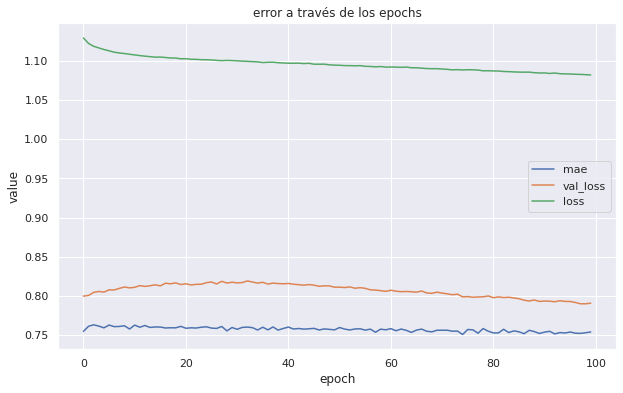

35/35 [==============================] - 0s 2ms/step
Evaluation metric results:
MSE is : 1.3260244020632823
MAE is : 0.8466898348858546
RMSE is : 1.1515313291714135
MAPE is : 42.42698372889038
Evaluation metric results:
MSE is : 0.9841827520262749
MAE is : 0.7786576281386224
RMSE is : 0.9920598530463144
MAPE is : 43.7691187288234
(2552, 5, 3) (2552, 1)
(1091, 5, 3) (1091, 1)
Epoch 1/100
128/128 [==============================] - 4s 10ms/step - loss: 1.1386 - mae: 0.7647 - val_loss: 0.7856 - val_mae: 0.6861
Epoch 2/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1232 - mae: 0.7639 - val_loss: 0.7883 - val_mae: 0.6903
Epoch 3/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1171 - mae: 0.7629 - val_loss: 0.7916 - val_mae: 0.6952
Epoch 4/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1144 - mae: 0.7615 - val_loss: 0.7915 - val_mae: 0.6963
Epoch 5/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1116 - mae: 

Epoch 59/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0929 - mae: 0.7602 - val_loss: 0.7939 - val_mae: 0.7115
Epoch 60/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0912 - mae: 0.7578 - val_loss: 0.7934 - val_mae: 0.7111
Epoch 61/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0920 - mae: 0.7597 - val_loss: 0.7947 - val_mae: 0.7124
Epoch 62/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0921 - mae: 0.7569 - val_loss: 0.7933 - val_mae: 0.7110
Epoch 63/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0916 - mae: 0.7602 - val_loss: 0.7943 - val_mae: 0.7124
Epoch 64/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0924 - mae: 0.7567 - val_loss: 0.7951 - val_mae: 0.7132
Epoch 65/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0913 - mae: 0.7548 - val_loss: 0.7928 - val_mae: 0.7109
Epoch 66/100
128/128 [==============================] - 1s 7ms

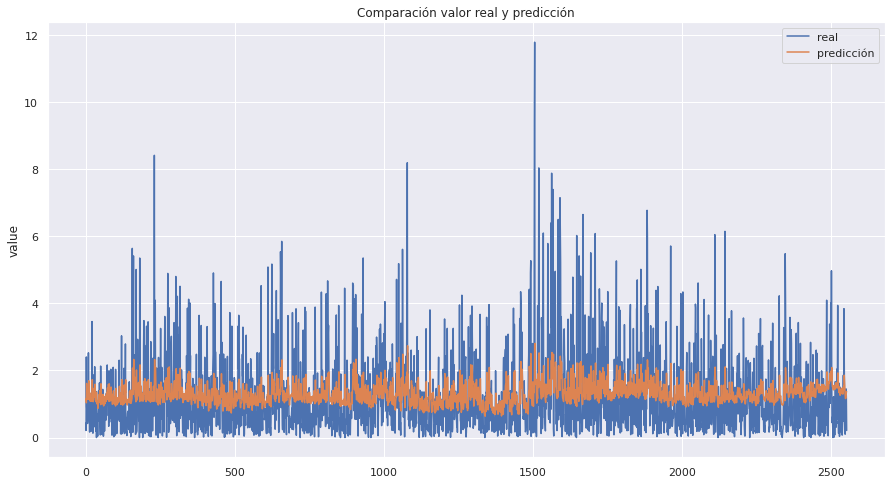

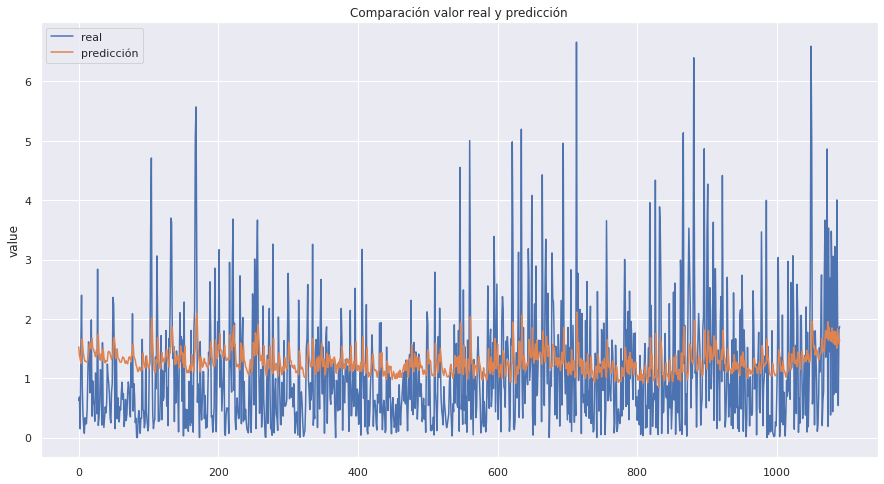

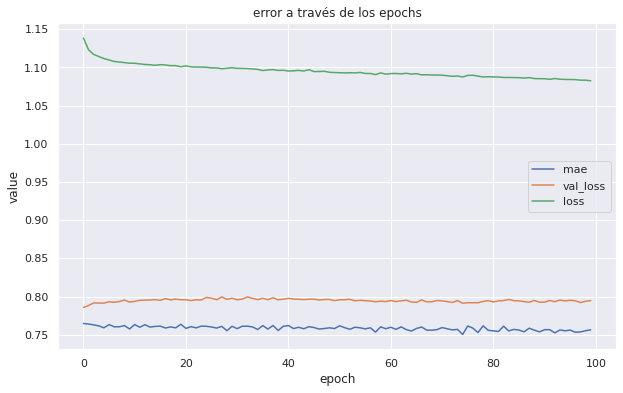

35/35 [==============================] - 0s 2ms/step
Evaluation metric results:
MSE is : 1.3264302780736028
MAE is : 0.8473659367009845
RMSE is : 1.1517075488480584
MAPE is : 42.35185454786033
Evaluation metric results:
MSE is : 1.029157355912104
MAE is : 0.7958105340955649
RMSE is : 1.0144739306222237
MAPE is : 44.592860994474584
(2552, 5, 3) (2552, 1)
(1091, 5, 3) (1091, 1)
Epoch 1/100
128/128 [==============================] - 4s 10ms/step - loss: 1.1579 - mae: 0.7712 - val_loss: 0.8019 - val_mae: 0.6977
Epoch 2/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1312 - mae: 0.7670 - val_loss: 0.8028 - val_mae: 0.7018
Epoch 3/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1228 - mae: 0.7642 - val_loss: 0.8032 - val_mae: 0.7052
Epoch 4/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1175 - mae: 0.7626 - val_loss: 0.8013 - val_mae: 0.7060
Epoch 5/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1134 - mae:

Epoch 59/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0901 - mae: 0.7582 - val_loss: 0.7697 - val_mae: 0.6950
Epoch 60/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0883 - mae: 0.7561 - val_loss: 0.7692 - val_mae: 0.6946
Epoch 61/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0891 - mae: 0.7577 - val_loss: 0.7713 - val_mae: 0.6966
Epoch 62/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0893 - mae: 0.7550 - val_loss: 0.7681 - val_mae: 0.6933
Epoch 63/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0884 - mae: 0.7581 - val_loss: 0.7708 - val_mae: 0.6968
Epoch 64/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0892 - mae: 0.7545 - val_loss: 0.7728 - val_mae: 0.6987
Epoch 65/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0882 - mae: 0.7528 - val_loss: 0.7668 - val_mae: 0.6921
Epoch 66/100
128/128 [==============================] - 1s 7ms

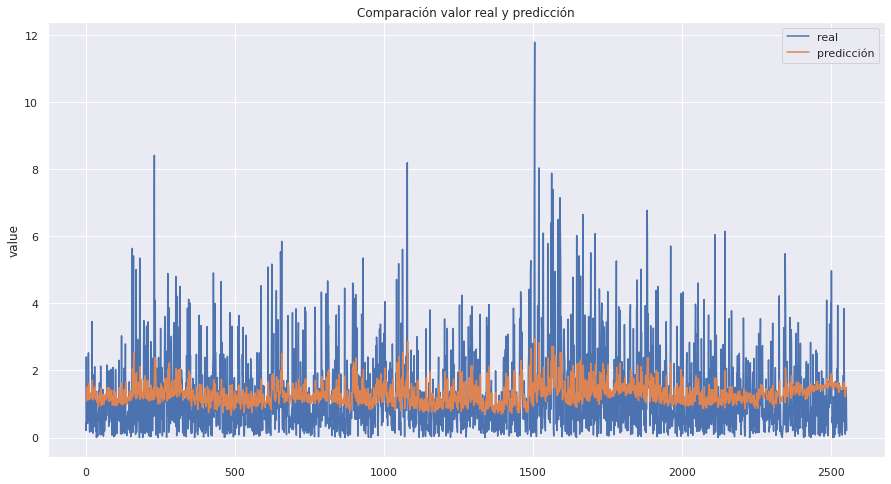

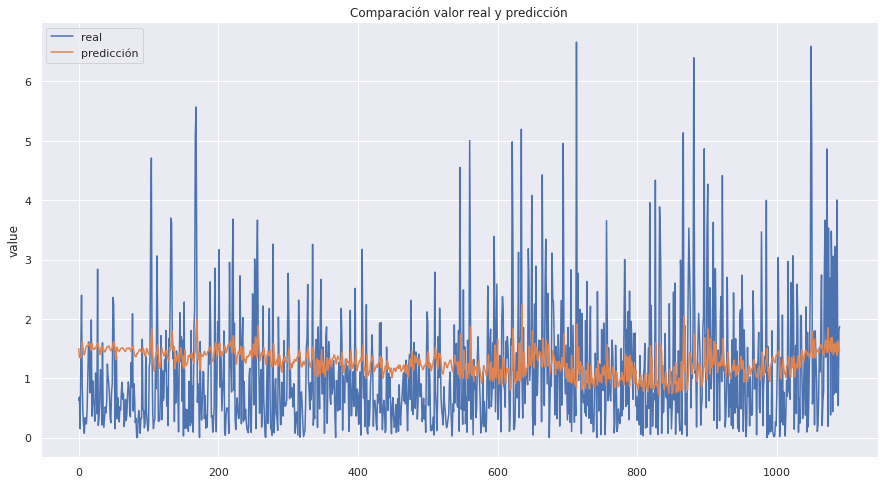

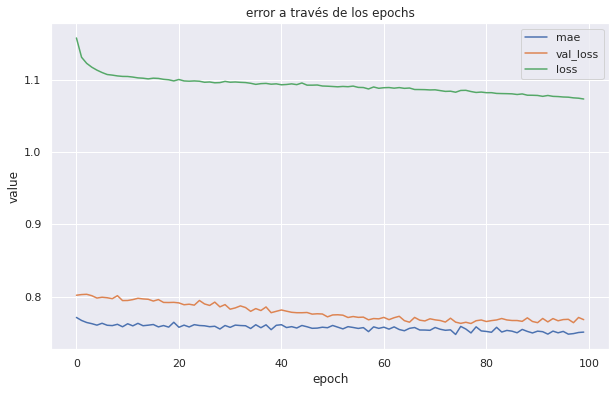

35/35 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.3090668372570977
MAE is : 0.8351209013108711
RMSE is : 1.1441445875662297
MAPE is : 41.322430676325354
Evaluation metric results:
MSE is : 1.0271305697721882
MAE is : 0.7764933469326244
RMSE is : 1.013474503760301
MAPE is : 41.82668388904543
(2552, 5, 3) (2552, 1)
(1091, 5, 3) (1091, 1)
Epoch 1/100
128/128 [==============================] - 4s 15ms/step - loss: 1.1334 - mae: 0.7677 - val_loss: 0.7885 - val_mae: 0.6881
Epoch 2/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1199 - mae: 0.7654 - val_loss: 0.7892 - val_mae: 0.6933
Epoch 3/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1139 - mae: 0.7630 - val_loss: 0.7864 - val_mae: 0.6915
Epoch 4/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1100 - mae: 0.7614 - val_loss: 0.7848 - val_mae: 0.6912
Epoch 5/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1091 - 

Epoch 59/100
128/128 [==============================] - 1s 10ms/step - loss: 1.0845 - mae: 0.7554 - val_loss: 0.7435 - val_mae: 0.6529
Epoch 60/100
128/128 [==============================] - 1s 10ms/step - loss: 1.0816 - mae: 0.7534 - val_loss: 0.7481 - val_mae: 0.6510
Epoch 61/100
128/128 [==============================] - 1s 10ms/step - loss: 1.0823 - mae: 0.7543 - val_loss: 0.7491 - val_mae: 0.6527
Epoch 62/100
128/128 [==============================] - 1s 10ms/step - loss: 1.0827 - mae: 0.7520 - val_loss: 0.7456 - val_mae: 0.6527
Epoch 63/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0809 - mae: 0.7549 - val_loss: 0.7443 - val_mae: 0.6570
Epoch 64/100
128/128 [==============================] - 1s 10ms/step - loss: 1.0824 - mae: 0.7515 - val_loss: 0.7474 - val_mae: 0.6571
Epoch 65/100
128/128 [==============================] - 1s 10ms/step - loss: 1.0804 - mae: 0.7491 - val_loss: 0.7550 - val_mae: 0.6494
Epoch 66/100
128/128 [==============================] - 

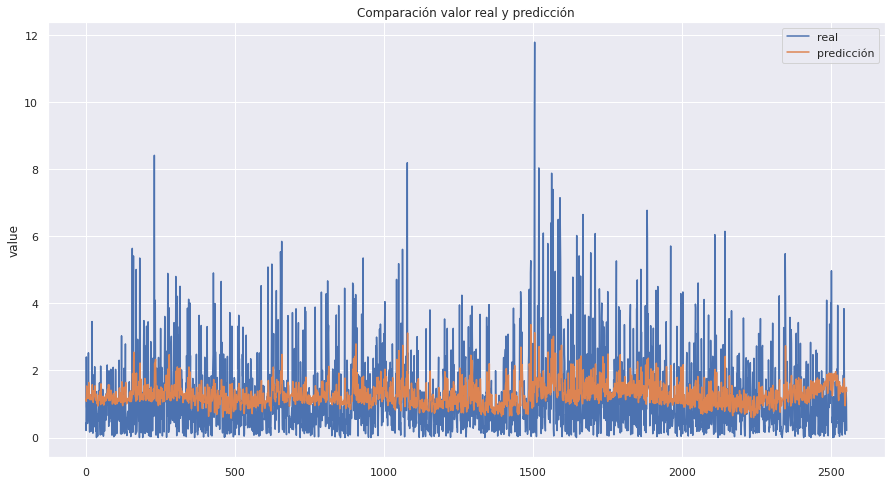

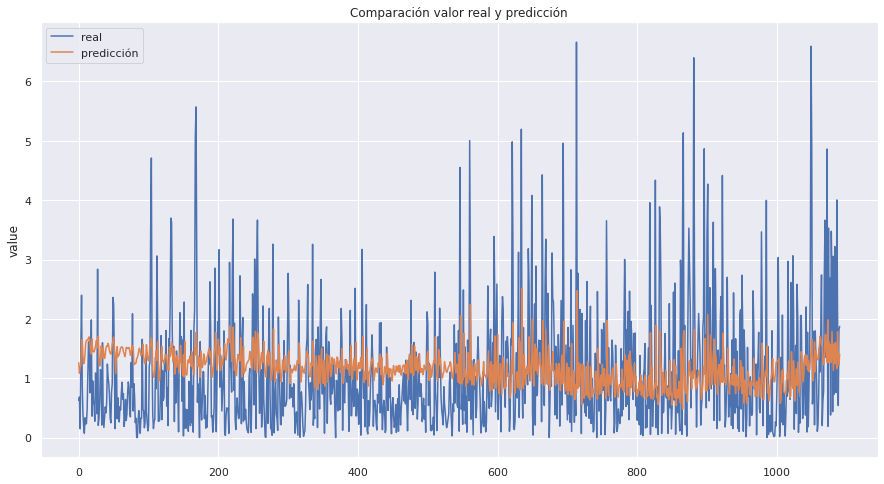

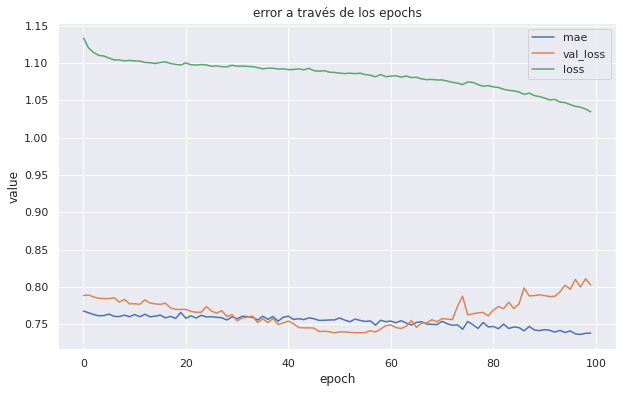

35/35 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.274798571677321
MAE is : 0.8202203398936567
RMSE is : 1.1290697815800939
MAPE is : 40.040163074381844
Evaluation metric results:
MSE is : 1.1200234376325724
MAE is : 0.7888416386618026
RMSE is : 1.0583115976084607
MAPE is : 40.57329965772832
(2552, 5, 3) (2552, 1)
(1091, 5, 3) (1091, 1)
Epoch 1/100
128/128 [==============================] - 6s 22ms/step - loss: 1.1338 - mae: 0.7682 - val_loss: 0.7865 - val_mae: 0.6923
Epoch 2/100
128/128 [==============================] - 2s 16ms/step - loss: 1.1198 - mae: 0.7653 - val_loss: 0.7893 - val_mae: 0.6997
Epoch 3/100
128/128 [==============================] - 2s 16ms/step - loss: 1.1131 - mae: 0.7622 - val_loss: 0.7828 - val_mae: 0.6943
Epoch 4/100
128/128 [==============================] - 2s 16ms/step - loss: 1.1083 - mae: 0.7611 - val_loss: 0.7824 - val_mae: 0.6922
Epoch 5/100
128/128 [==============================] - 2s 16ms/step - loss: 1.1089 - 

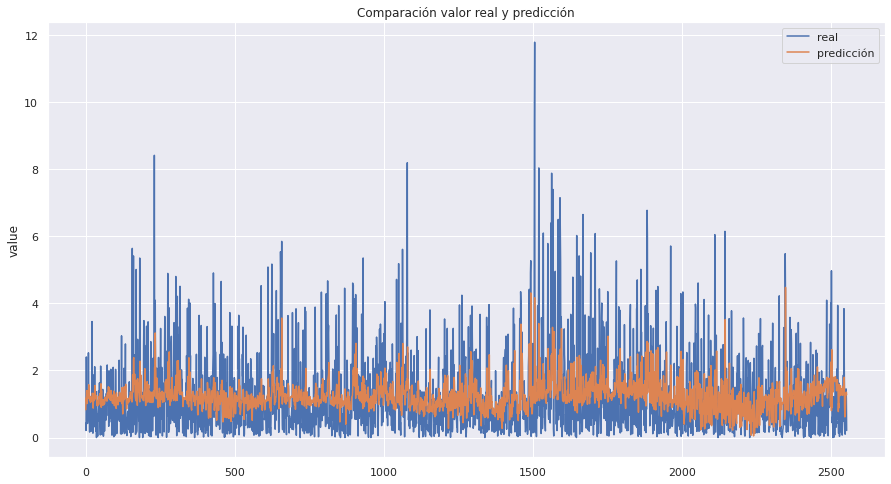

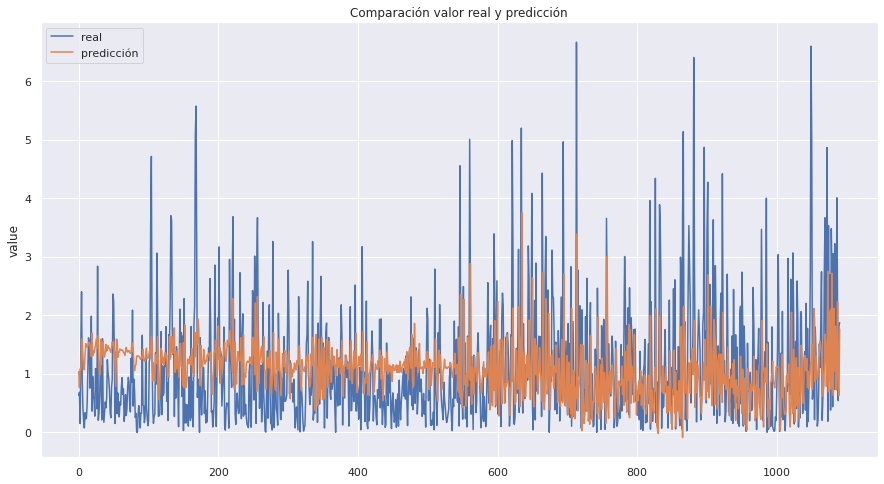

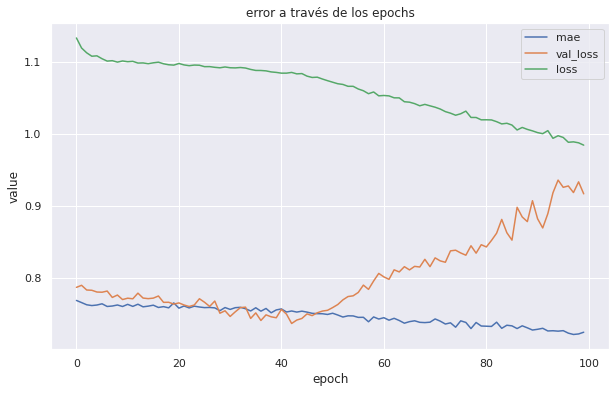

35/35 [==============================] - 0s 5ms/step
Evaluation metric results:
MSE is : 1.2458377077698872
MAE is : 0.8116100862587637
RMSE is : 1.1161710029246805
MAPE is : 39.36517654378704
Evaluation metric results:
MSE is : 1.3320522730380564
MAE is : 0.8667943731500352
RMSE is : 1.1541456896934876
MAPE is : 44.213537461656045
(2552, 5, 3) (2552, 1)
(1091, 5, 3) (1091, 1)
Epoch 1/100
128/128 [==============================] - 5s 25ms/step - loss: 1.1341 - mae: 0.7682 - val_loss: 0.7885 - val_mae: 0.6989
Epoch 2/100
128/128 [==============================] - 3s 22ms/step - loss: 1.1182 - mae: 0.7648 - val_loss: 0.7908 - val_mae: 0.7064
Epoch 3/100
128/128 [==============================] - 3s 20ms/step - loss: 1.1107 - mae: 0.7612 - val_loss: 0.7813 - val_mae: 0.6986
Epoch 4/100
128/128 [==============================] - 3s 20ms/step - loss: 1.1057 - mae: 0.7607 - val_loss: 0.7815 - val_mae: 0.6972
Epoch 5/100
128/128 [==============================] - 3s 20ms/step - loss: 1.1073 -

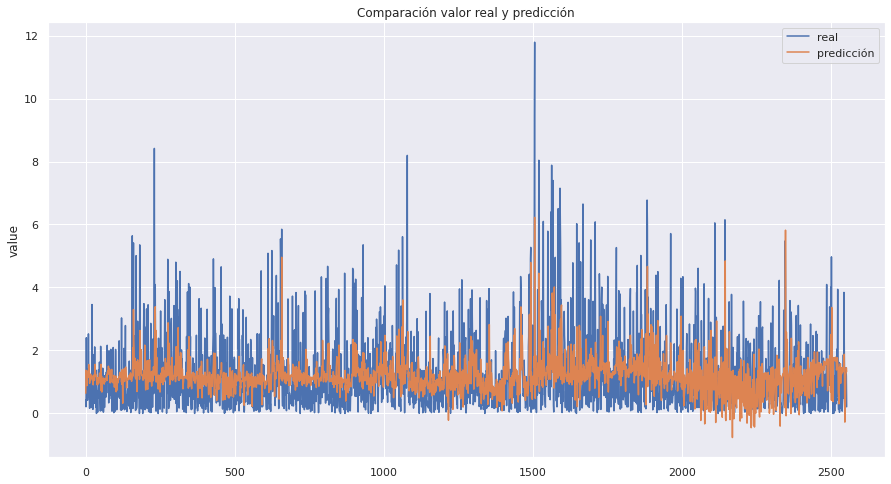

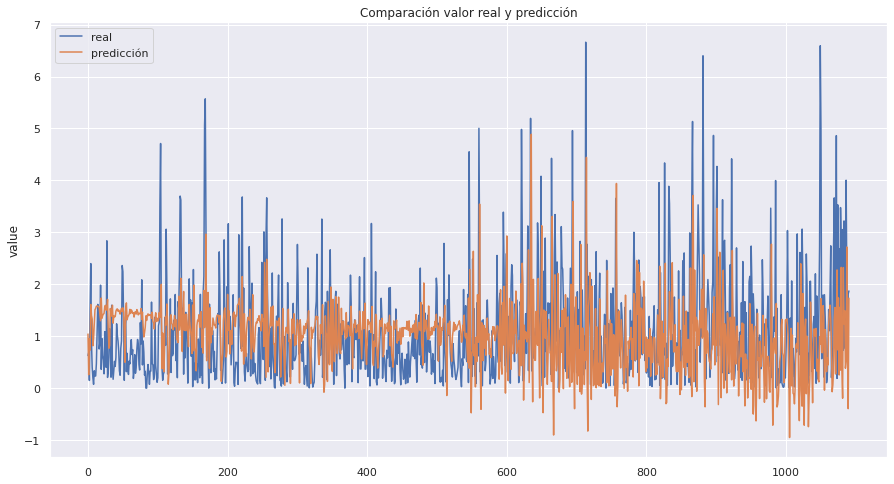

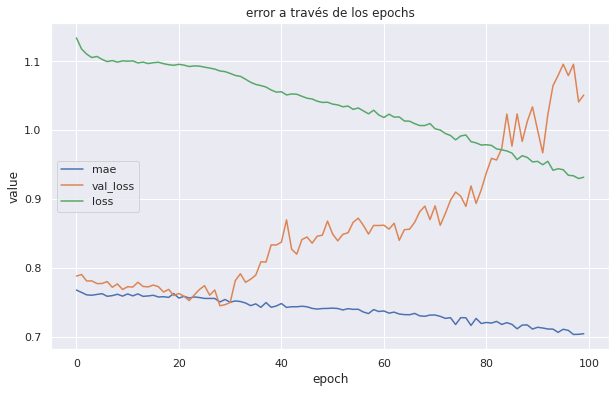

35/35 [==============================] - 0s 11ms/step
Evaluation metric results:
MSE is : 1.2118949779002228
MAE is : 0.8147623760774777
RMSE is : 1.1008610166139152
MAPE is : 40.603602089327225
Evaluation metric results:
MSE is : 1.6479541173497054
MAE is : 0.9897477185867486
RMSE is : 1.2837266521147348
MAPE is : 52.00760529056894
(2549, 8, 3) (2549, 1)
(1088, 8, 3) (1088, 1)
Epoch 1/100
128/128 [==============================] - 4s 14ms/step - loss: 1.1782 - mae: 0.7710 - val_loss: 0.8133 - val_mae: 0.6903
Epoch 2/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1365 - mae: 0.7593 - val_loss: 0.8099 - val_mae: 0.6921
Epoch 3/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1263 - mae: 0.7639 - val_loss: 0.8083 - val_mae: 0.6924
Epoch 4/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1207 - mae: 0.7632 - val_loss: 0.8070 - val_mae: 0.6920
Epoch 5/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1176 - ma

Epoch 59/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0910 - mae: 0.7555 - val_loss: 0.7869 - val_mae: 0.6795
Epoch 60/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0909 - mae: 0.7562 - val_loss: 0.7868 - val_mae: 0.6798
Epoch 61/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0909 - mae: 0.7578 - val_loss: 0.7867 - val_mae: 0.6795
Epoch 62/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0904 - mae: 0.7605 - val_loss: 0.7860 - val_mae: 0.6787
Epoch 63/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0907 - mae: 0.7573 - val_loss: 0.7858 - val_mae: 0.6786
Epoch 64/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0903 - mae: 0.7590 - val_loss: 0.7855 - val_mae: 0.6783
Epoch 65/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0903 - mae: 0.7562 - val_loss: 0.7848 - val_mae: 0.6776
Epoch 66/100
128/128 [==============================] - 1s 9ms

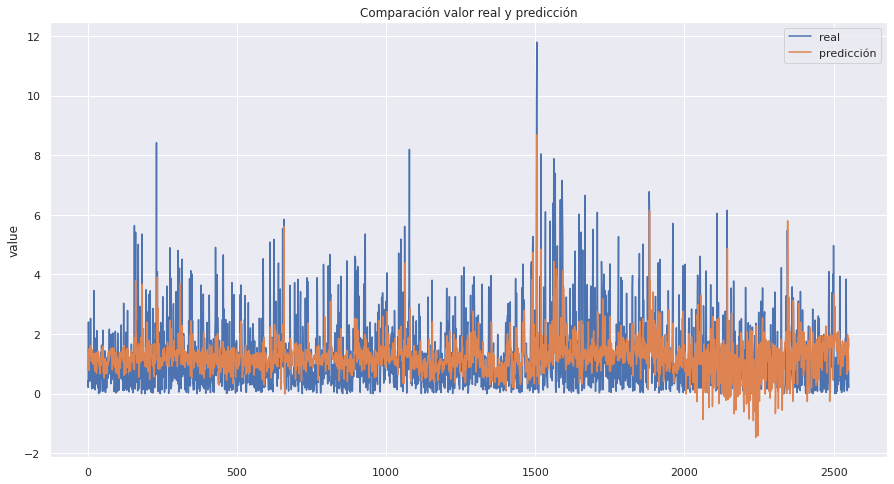

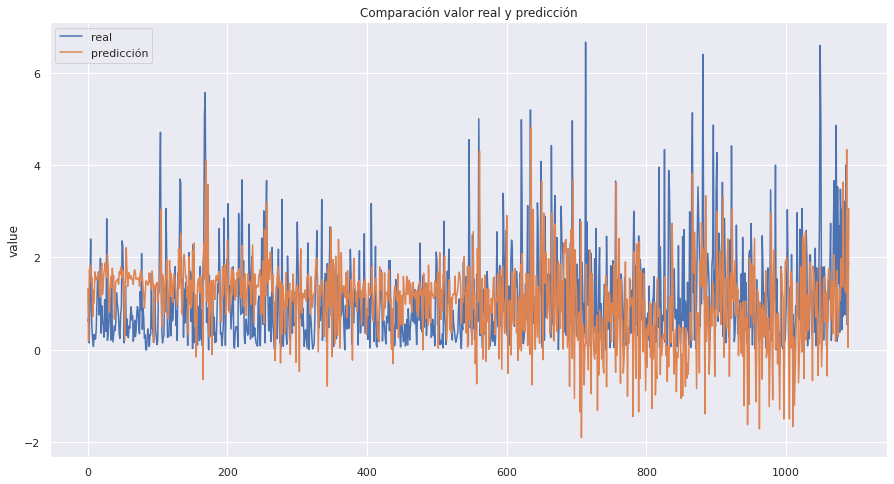

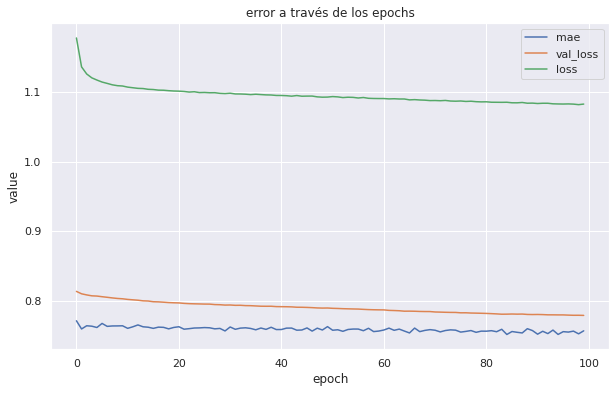

34/34 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.322609770738242
MAE is : 0.8394682398669828
RMSE is : 1.1500477254176202
MAPE is : 41.37313525736456
Evaluation metric results:
MSE is : 0.9798413619855805
MAE is : 0.7361282040267616
RMSE is : 0.9898693661213991
MAPE is : 38.04046102424003
(2549, 8, 3) (2549, 1)
(1088, 8, 3) (1088, 1)
Epoch 1/100
128/128 [==============================] - 5s 14ms/step - loss: 1.1382 - mae: 0.7639 - val_loss: 0.7888 - val_mae: 0.6879
Epoch 2/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1228 - mae: 0.7615 - val_loss: 0.7899 - val_mae: 0.6895
Epoch 3/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1183 - mae: 0.7630 - val_loss: 0.7926 - val_mae: 0.6935
Epoch 4/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1151 - mae: 0.7625 - val_loss: 0.7939 - val_mae: 0.6954
Epoch 5/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1125 - mae: 

Epoch 59/100
128/128 [==============================] - 1s 10ms/step - loss: 1.0842 - mae: 0.7534 - val_loss: 0.7815 - val_mae: 0.6912
Epoch 60/100
128/128 [==============================] - 1s 10ms/step - loss: 1.0839 - mae: 0.7529 - val_loss: 0.7812 - val_mae: 0.6908
Epoch 61/100
128/128 [==============================] - 1s 10ms/step - loss: 1.0854 - mae: 0.7568 - val_loss: 0.7807 - val_mae: 0.6900
Epoch 62/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0839 - mae: 0.7585 - val_loss: 0.7812 - val_mae: 0.6918
Epoch 63/100
128/128 [==============================] - 1s 10ms/step - loss: 1.0837 - mae: 0.7534 - val_loss: 0.7811 - val_mae: 0.6915
Epoch 64/100
128/128 [==============================] - 1s 10ms/step - loss: 1.0843 - mae: 0.7577 - val_loss: 0.7800 - val_mae: 0.6903
Epoch 65/100
128/128 [==============================] - 1s 10ms/step - loss: 1.0835 - mae: 0.7537 - val_loss: 0.7793 - val_mae: 0.6894
Epoch 66/100
128/128 [==============================] - 

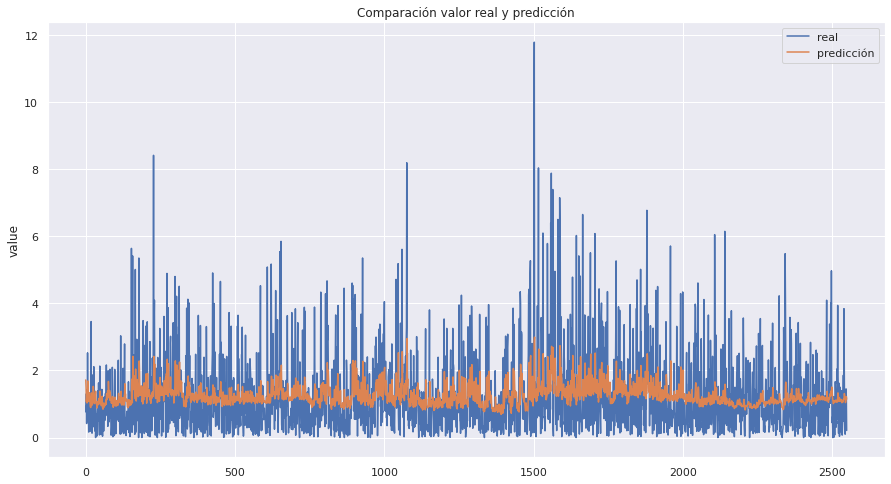

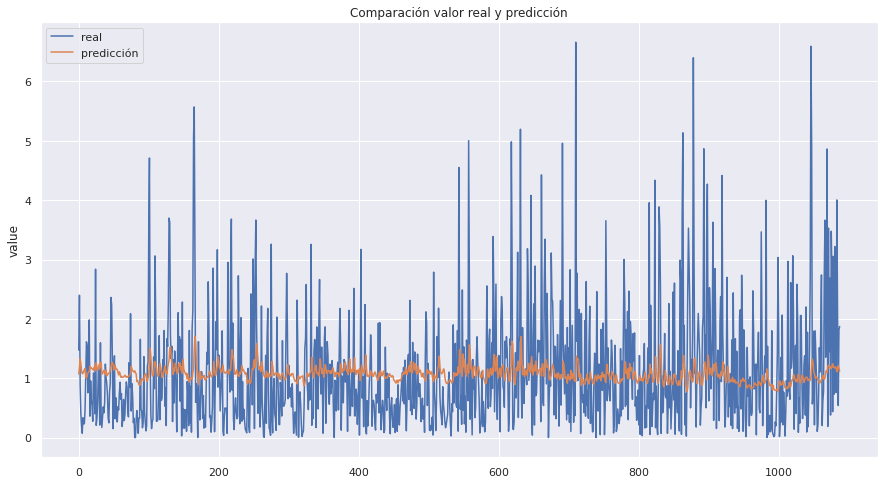

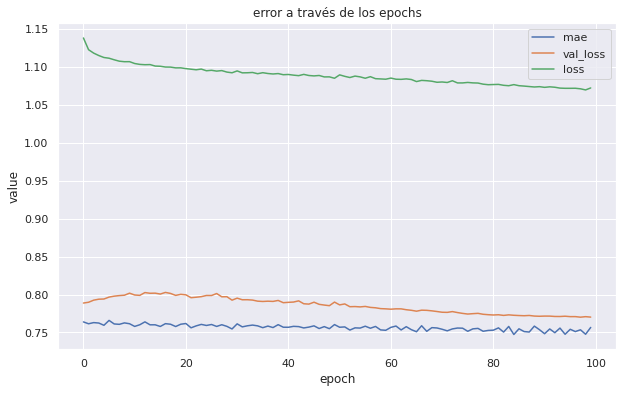

34/34 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.3053767574303636
MAE is : 0.830577988151819
RMSE is : 1.1425308562268082
MAPE is : 40.55831891187782
Evaluation metric results:
MSE is : 0.9767002681615784
MAE is : 0.7391847100151128
RMSE is : 0.9882814721331056
MAPE is : 38.61464656443621
(2549, 8, 3) (2549, 1)
(1088, 8, 3) (1088, 1)
Epoch 1/100
128/128 [==============================] - 5s 16ms/step - loss: 1.1372 - mae: 0.7668 - val_loss: 0.7908 - val_mae: 0.6763
Epoch 2/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1183 - mae: 0.7628 - val_loss: 0.7916 - val_mae: 0.6782
Epoch 3/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1150 - mae: 0.7617 - val_loss: 0.7899 - val_mae: 0.6780
Epoch 4/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1114 - mae: 0.7634 - val_loss: 0.7890 - val_mae: 0.6823
Epoch 5/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1079 - m

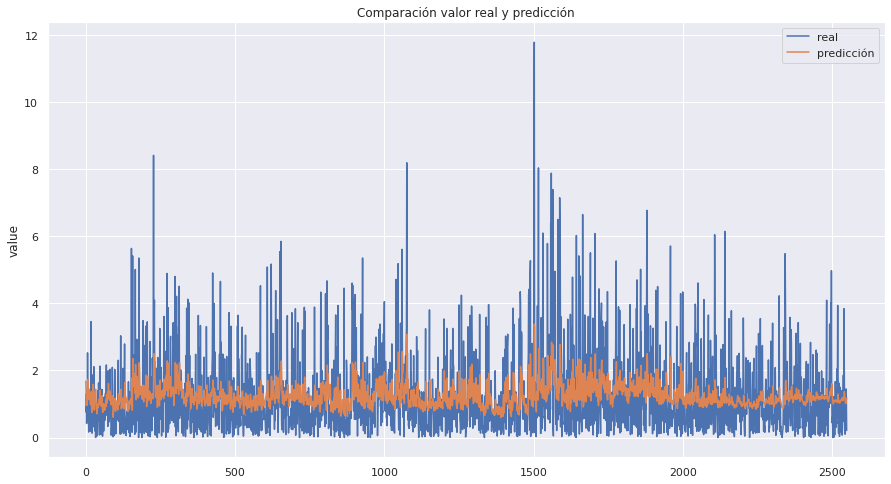

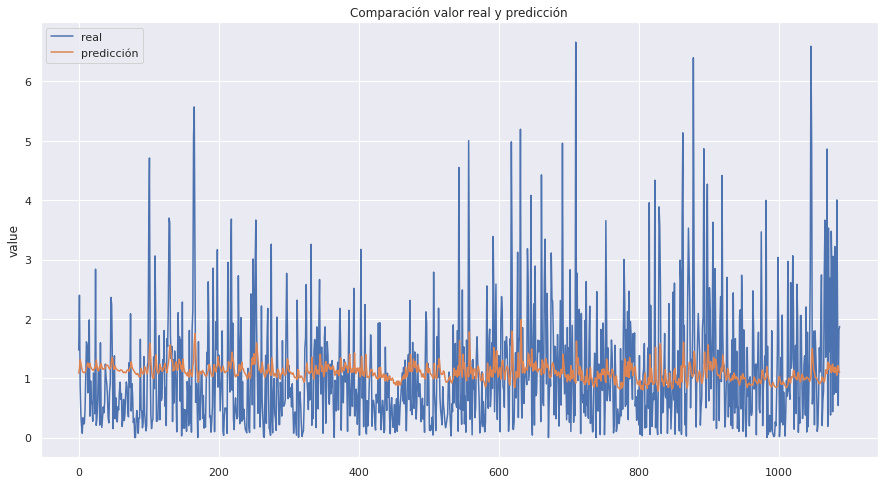

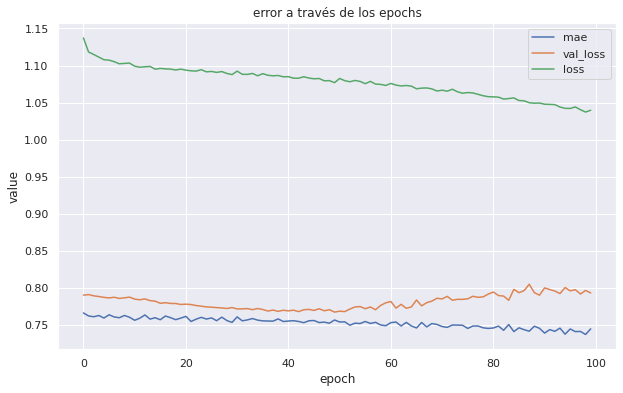

34/34 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.2726283396105493
MAE is : 0.8170654034759092
RMSE is : 1.1281083013658526
MAPE is : 39.33796708287186
Evaluation metric results:
MSE is : 1.0204605811692895
MAE is : 0.7258178562962234
RMSE is : 1.0101784897577701
MAPE is : 35.304066655740684
(2549, 8, 3) (2549, 1)
(1088, 8, 3) (1088, 1)
Epoch 1/100
128/128 [==============================] - 7s 21ms/step - loss: 1.1480 - mae: 0.7715 - val_loss: 0.7979 - val_mae: 0.6884
Epoch 2/100
128/128 [==============================] - 2s 16ms/step - loss: 1.1234 - mae: 0.7653 - val_loss: 0.7979 - val_mae: 0.6875
Epoch 3/100
128/128 [==============================] - 2s 16ms/step - loss: 1.1192 - mae: 0.7639 - val_loss: 0.7917 - val_mae: 0.6802
Epoch 4/100
128/128 [==============================] - 2s 15ms/step - loss: 1.1136 - mae: 0.7645 - val_loss: 0.7924 - val_mae: 0.6911
Epoch 5/100
128/128 [==============================] - 2s 15ms/step - loss: 1.1111 -

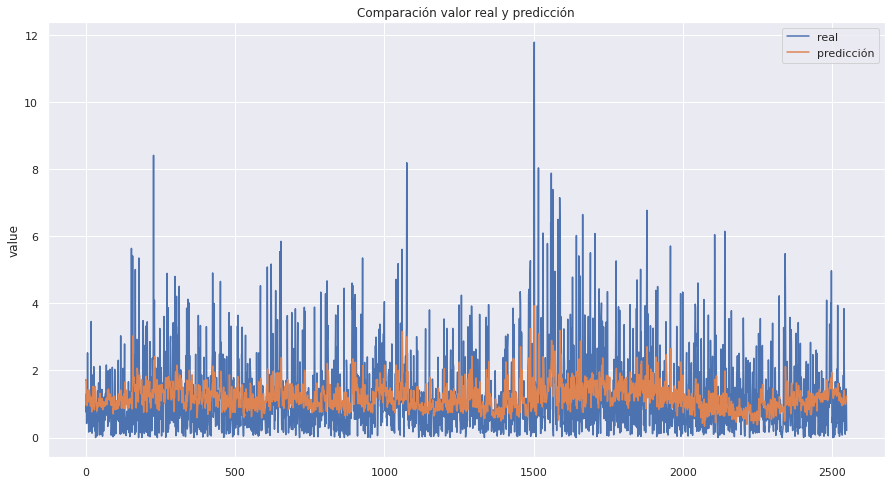

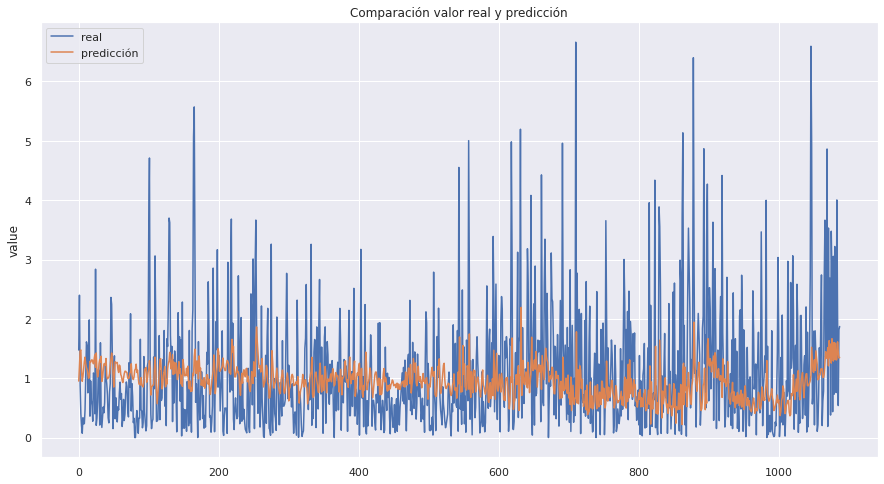

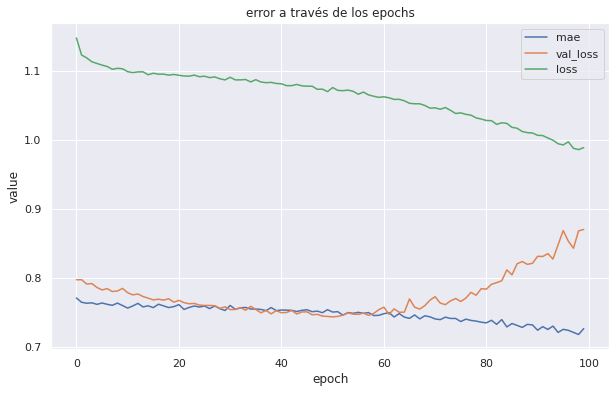

34/34 [==============================] - 0s 5ms/step
Evaluation metric results:
MSE is : 1.226257704972454
MAE is : 0.8046655499528688
RMSE is : 1.1073652084892562
MAPE is : 38.96621280440925
Evaluation metric results:
MSE is : 1.2775540509566725
MAE is : 0.8470349957488426
RMSE is : 1.130289366028307
MAPE is : 43.07272613785235
(2549, 8, 3) (2549, 1)
(1088, 8, 3) (1088, 1)
Epoch 1/100
128/128 [==============================] - 5s 21ms/step - loss: 1.1434 - mae: 0.7706 - val_loss: 0.7867 - val_mae: 0.6764
Epoch 2/100
128/128 [==============================] - 2s 16ms/step - loss: 1.1189 - mae: 0.7621 - val_loss: 0.7931 - val_mae: 0.6855
Epoch 3/100
128/128 [==============================] - 2s 17ms/step - loss: 1.1162 - mae: 0.7618 - val_loss: 0.7837 - val_mae: 0.6742
Epoch 4/100
128/128 [==============================] - 2s 17ms/step - loss: 1.1099 - mae: 0.7631 - val_loss: 0.7870 - val_mae: 0.6937
Epoch 5/100
128/128 [==============================] - 2s 16ms/step - loss: 1.1083 - ma

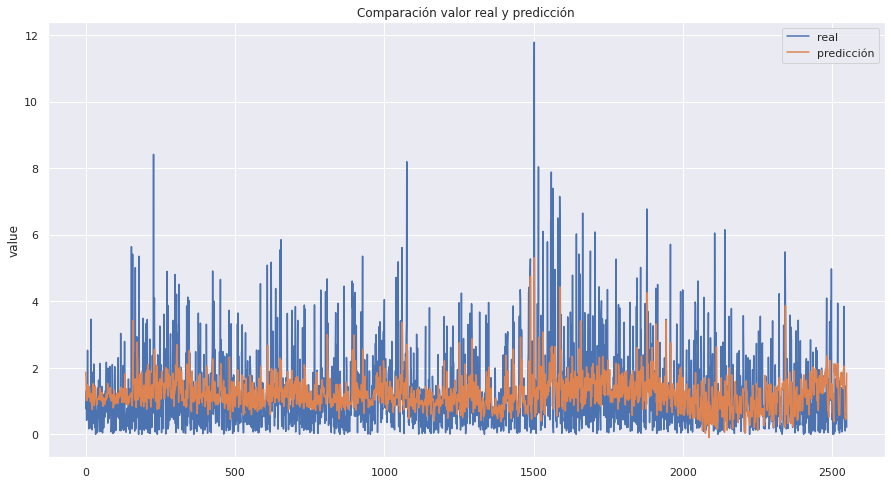

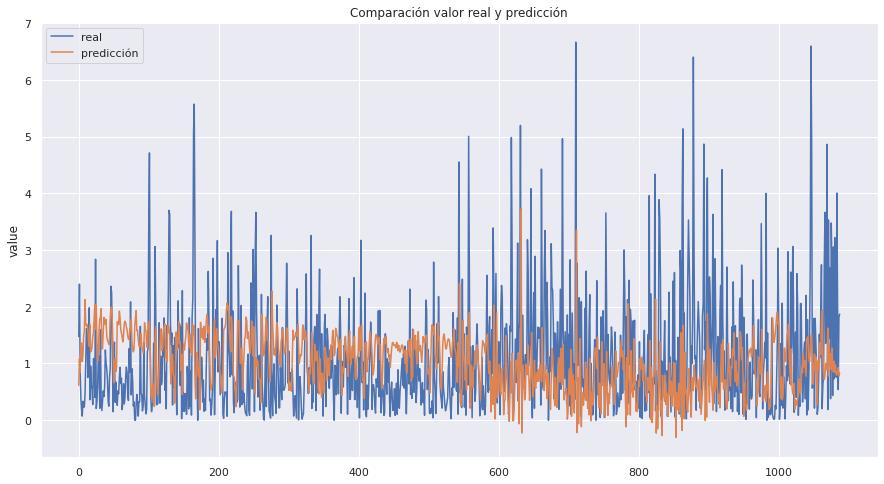

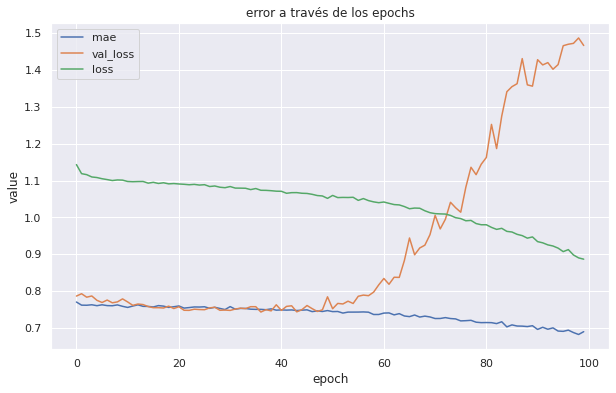

34/34 [==============================] - 0s 9ms/step
Evaluation metric results:
MSE is : 1.2593699115765509
MAE is : 0.8186570495594151
RMSE is : 1.1222165172445784
MAPE is : 40.58142298436398
Evaluation metric results:
MSE is : 1.9074936202580852
MAE is : 1.0837532808051114
RMSE is : 1.3811204220697357
MAPE is : 59.250426524673074
(2549, 8, 3) (2549, 1)
(1088, 8, 3) (1088, 1)
Epoch 1/100
128/128 [==============================] - 10s 52ms/step - loss: 1.1381 - mae: 0.7689 - val_loss: 0.7755 - val_mae: 0.6719
Epoch 2/100
128/128 [==============================] - 6s 46ms/step - loss: 1.1127 - mae: 0.7604 - val_loss: 0.7852 - val_mae: 0.6861
Epoch 3/100
128/128 [==============================] - 6s 50ms/step - loss: 1.1102 - mae: 0.7598 - val_loss: 0.7720 - val_mae: 0.6728
Epoch 4/100
128/128 [==============================] - 6s 46ms/step - loss: 1.1048 - mae: 0.7622 - val_loss: 0.7787 - val_mae: 0.6936
Epoch 5/100
128/128 [==============================] - 6s 46ms/step - loss: 1.1038 

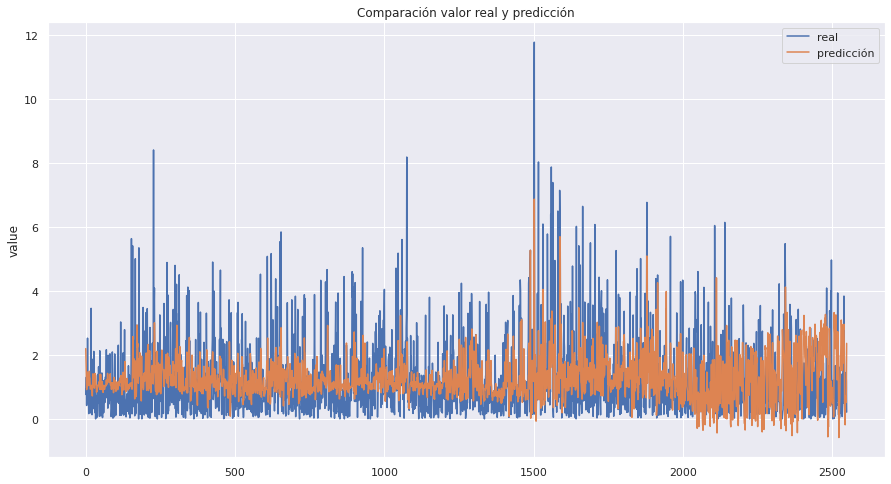

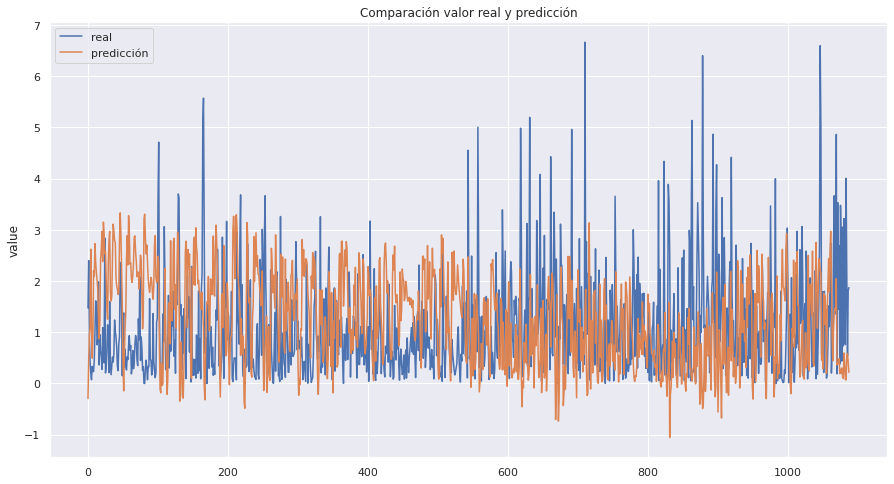

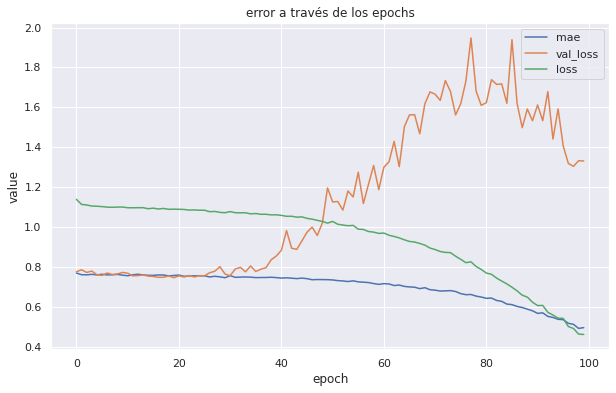

34/34 [==============================] - 1s 20ms/step
Evaluation metric results:
MSE is : 0.7740579406625442
MAE is : 0.627077827013824
RMSE is : 0.8798056266372386
MAPE is : 32.104672958759934
Evaluation metric results:
MSE is : 1.6910763745416764
MAE is : 0.9925486979219033
RMSE is : 1.3004139243109005
MAPE is : 53.811592489184875
(2547, 10, 3) (2547, 1)
(1086, 10, 3) (1086, 1)
Epoch 1/100
128/128 [==============================] - 5s 18ms/step - loss: 1.2102 - mae: 0.7781 - val_loss: 0.8097 - val_mae: 0.6800
Epoch 2/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1690 - mae: 0.7779 - val_loss: 0.8024 - val_mae: 0.6784
Epoch 3/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1473 - mae: 0.7700 - val_loss: 0.7987 - val_mae: 0.6804
Epoch 4/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1352 - mae: 0.7704 - val_loss: 0.7972 - val_mae: 0.6828
Epoch 5/100
128/128 [==============================] - 1s 11ms/step - loss: 1.127

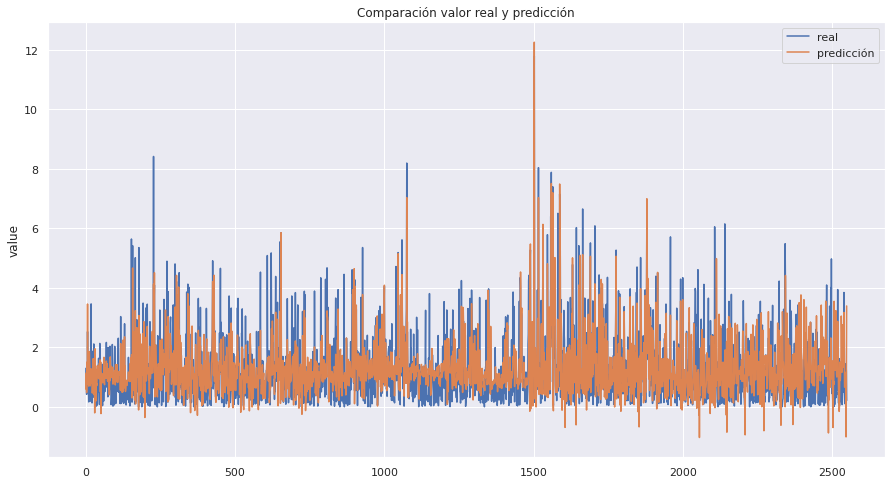

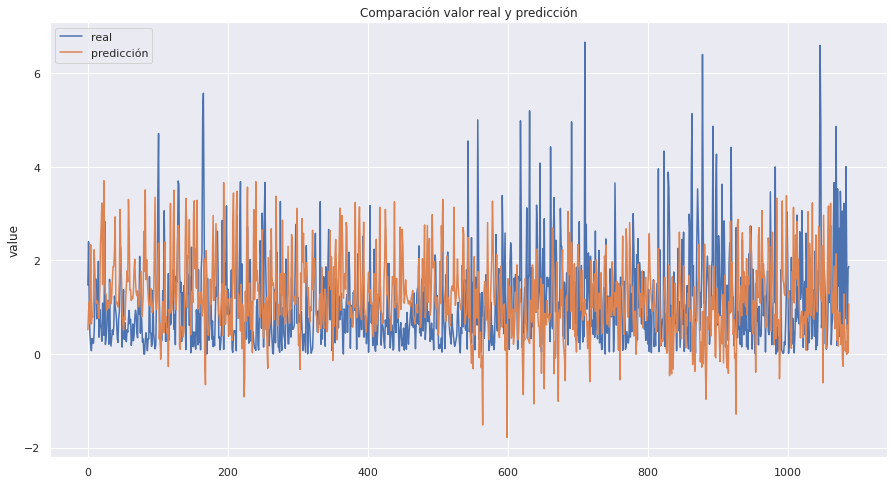

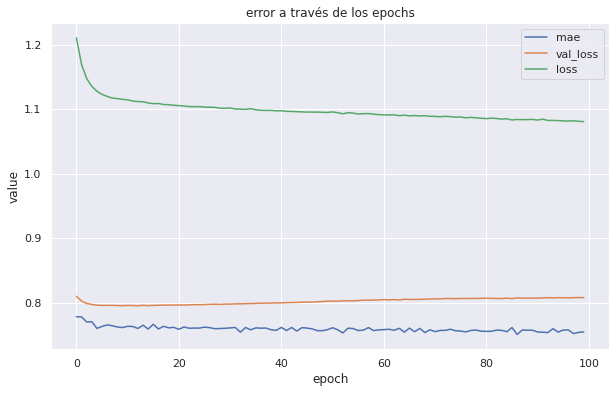

34/34 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.327852997151658
MAE is : 0.8415073153302122
RMSE is : 1.1523250397139073
MAPE is : 41.37269016230272
Evaluation metric results:
MSE is : 1.0290844659053384
MAE is : 0.7557468290483149
RMSE is : 1.0144380049590702
MAPE is : 39.27742637666222
(2547, 10, 3) (2547, 1)
(1086, 10, 3) (1086, 1)
Epoch 1/100
128/128 [==============================] - 5s 15ms/step - loss: 1.1576 - mae: 0.7853 - val_loss: 0.8292 - val_mae: 0.6574
Epoch 2/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1307 - mae: 0.7666 - val_loss: 0.8160 - val_mae: 0.6592
Epoch 3/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1237 - mae: 0.7630 - val_loss: 0.8094 - val_mae: 0.6606
Epoch 4/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1199 - mae: 0.7673 - val_loss: 0.8002 - val_mae: 0.6628
Epoch 5/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1172 - ma

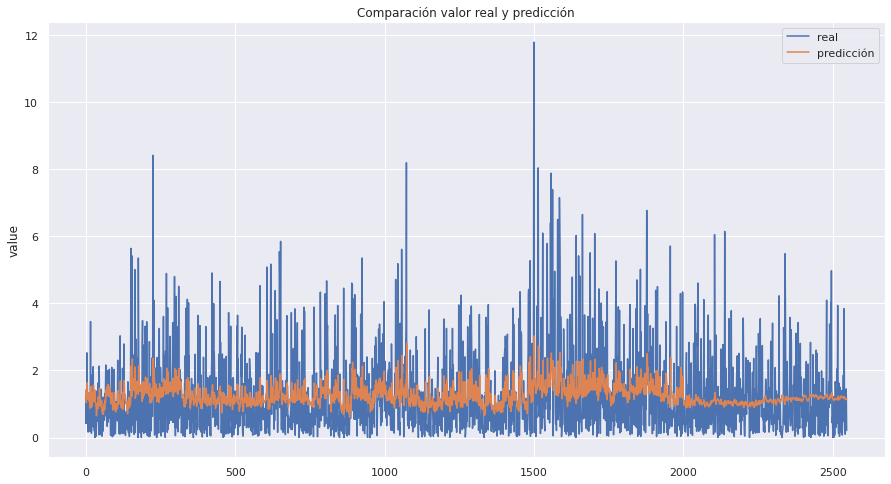

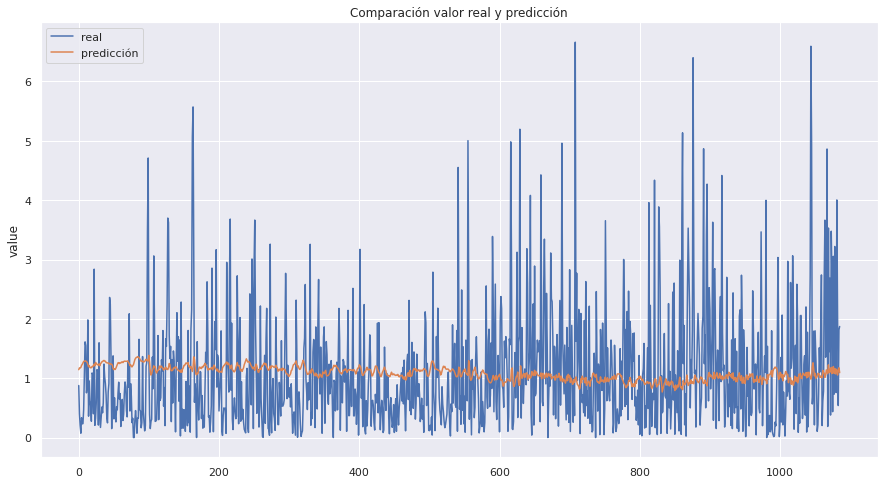

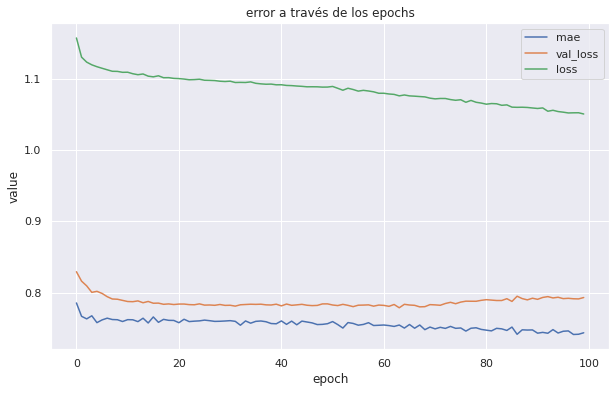

34/34 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.2898141707977686
MAE is : 0.8194601078628696
RMSE is : 1.1356998594689394
MAPE is : 39.5359326455529
Evaluation metric results:
MSE is : 1.014471245778219
MAE is : 0.713523405381907
RMSE is : 1.0072096334816396
MAPE is : 34.02952492535773
(2547, 10, 3) (2547, 1)
(1086, 10, 3) (1086, 1)
Epoch 1/100
128/128 [==============================] - 5s 18ms/step - loss: 1.1591 - mae: 0.7707 - val_loss: 0.7972 - val_mae: 0.6856
Epoch 2/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1344 - mae: 0.7693 - val_loss: 0.7957 - val_mae: 0.6894
Epoch 3/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1241 - mae: 0.7643 - val_loss: 0.7953 - val_mae: 0.6923
Epoch 4/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1189 - mae: 0.7688 - val_loss: 0.8031 - val_mae: 0.7045
Epoch 5/100
128/128 [==============================] - 1s 12ms/step - loss: 1.1162 - m

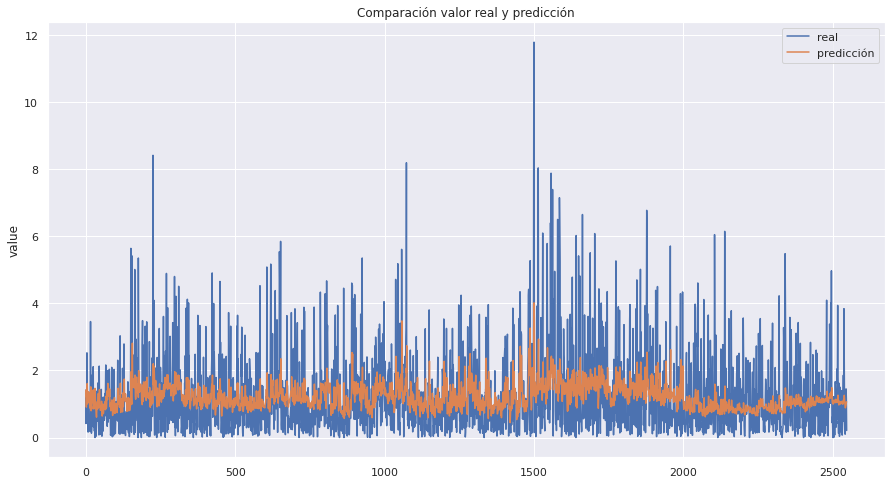

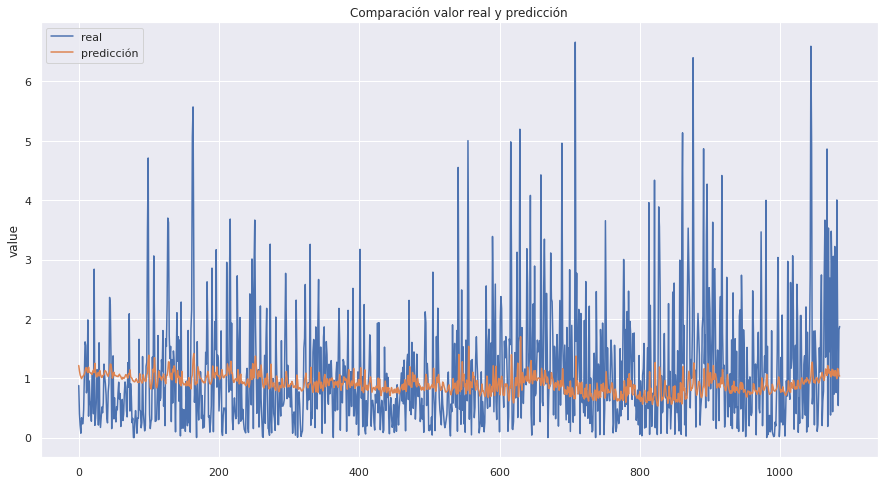

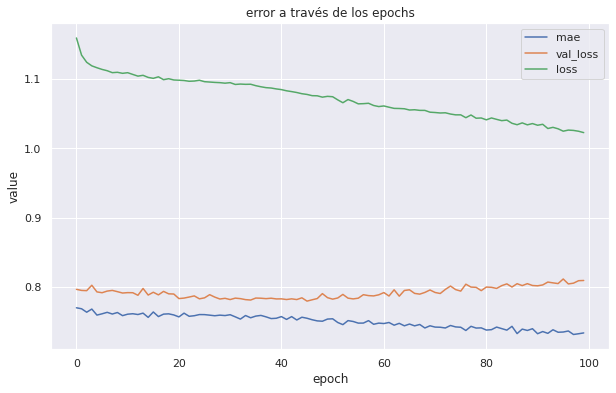

34/34 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.2595799048958107
MAE is : 0.8233734416696281
RMSE is : 1.1223100752001698
MAPE is : 40.76913733361597
Evaluation metric results:
MSE is : 1.0216036640413397
MAE is : 0.7602763008029301
RMSE is : 1.0107441140275513
MAPE is : 40.00482306266364
(2547, 10, 3) (2547, 1)
(1086, 10, 3) (1086, 1)
Epoch 1/100
128/128 [==============================] - 6s 18ms/step - loss: 1.1499 - mae: 0.7709 - val_loss: 0.7987 - val_mae: 0.6860
Epoch 2/100
128/128 [==============================] - 2s 13ms/step - loss: 1.1299 - mae: 0.7687 - val_loss: 0.7952 - val_mae: 0.6887
Epoch 3/100
128/128 [==============================] - 2s 15ms/step - loss: 1.1192 - mae: 0.7628 - val_loss: 0.7907 - val_mae: 0.6868
Epoch 4/100
128/128 [==============================] - 2s 12ms/step - loss: 1.1147 - mae: 0.7668 - val_loss: 0.8027 - val_mae: 0.7051
Epoch 5/100
128/128 [==============================] - 2s 12ms/step - loss: 1.1115 

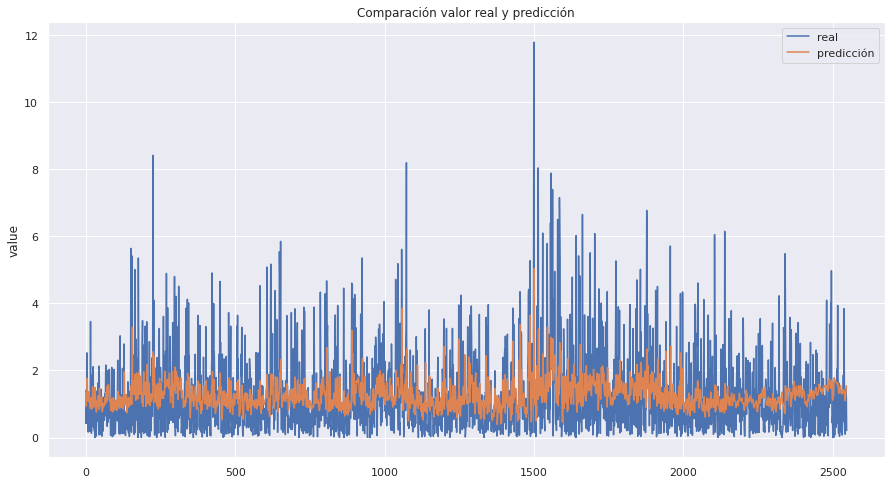

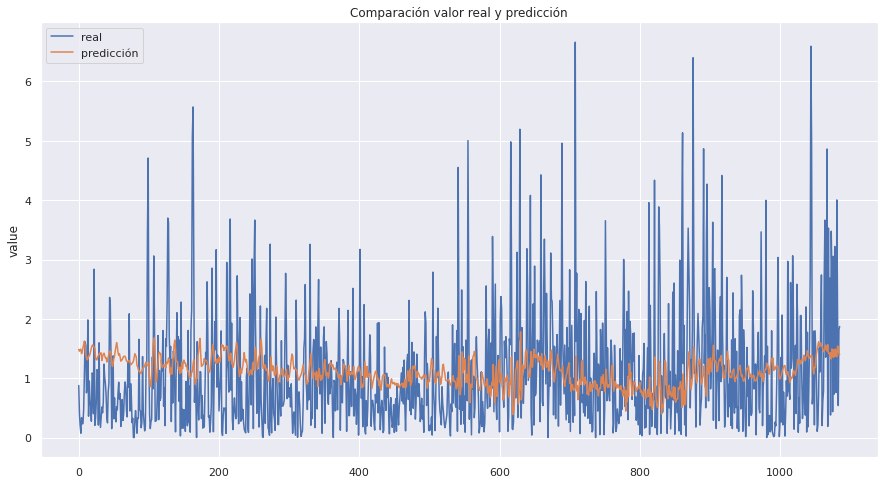

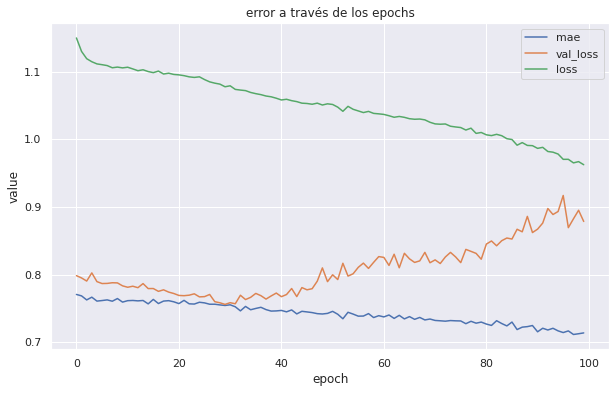

34/34 [==============================] - 0s 8ms/step
Evaluation metric results:
MSE is : 1.2025039306508822
MAE is : 0.8120777661705458
RMSE is : 1.0965874021941353
MAPE is : 40.84069482984842
Evaluation metric results:
MSE is : 1.1427131963266097
MAE is : 0.8455312179908788
RMSE is : 1.0689776407047107
MAPE is : 47.90217681352422
(2547, 10, 3) (2547, 1)
(1086, 10, 3) (1086, 1)
Epoch 1/100
128/128 [==============================] - 8s 37ms/step - loss: 1.1491 - mae: 0.7725 - val_loss: 0.7906 - val_mae: 0.6801
Epoch 2/100
128/128 [==============================] - 4s 28ms/step - loss: 1.1255 - mae: 0.7676 - val_loss: 0.7882 - val_mae: 0.6864
Epoch 3/100
128/128 [==============================] - 4s 28ms/step - loss: 1.1156 - mae: 0.7622 - val_loss: 0.7793 - val_mae: 0.6797
Epoch 4/100
128/128 [==============================] - 4s 29ms/step - loss: 1.1112 - mae: 0.7655 - val_loss: 0.7952 - val_mae: 0.7049
Epoch 5/100
128/128 [==============================] - 4s 29ms/step - loss: 1.1077 

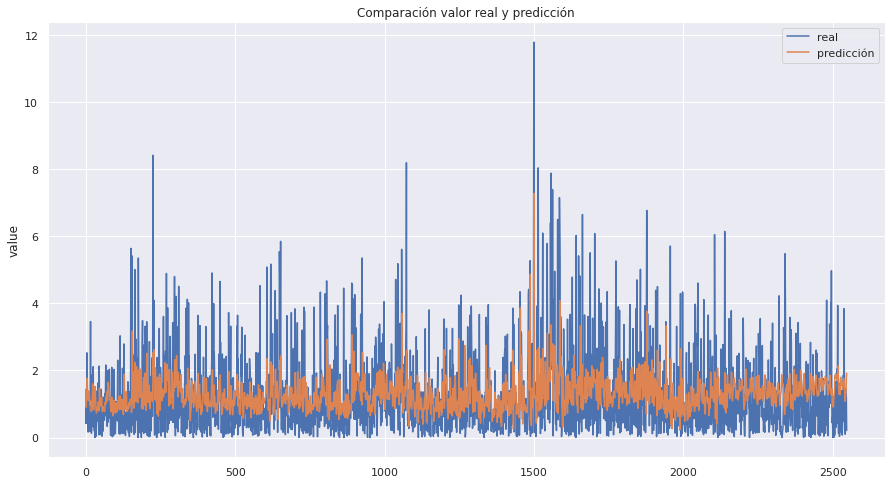

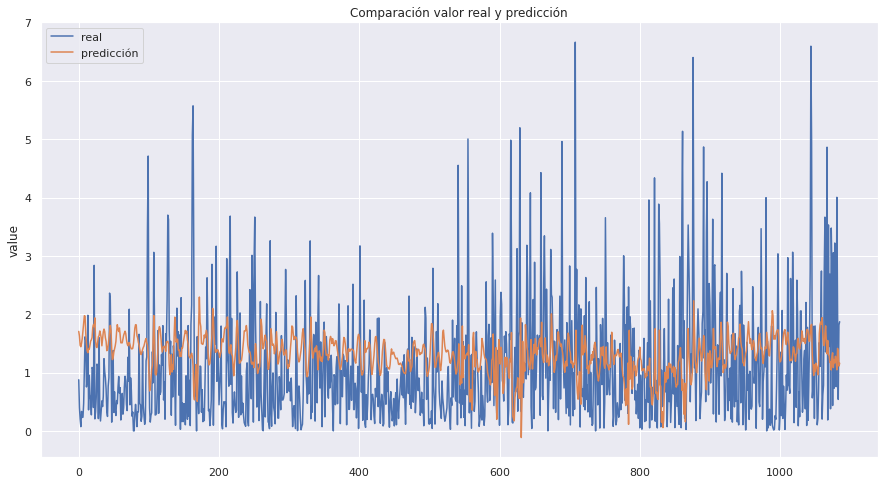

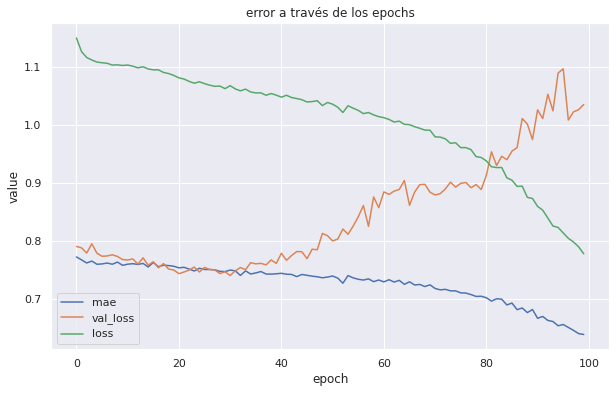

34/34 [==============================] - 0s 11ms/step
Evaluation metric results:
MSE is : 1.0399305762838957
MAE is : 0.7481848111939077
RMSE is : 1.0197698643732789
MAPE is : 37.640170119345804
Evaluation metric results:
MSE is : 1.355152554928255
MAE is : 0.934037830189799
RMSE is : 1.1641101987905849
MAPE is : 53.57230289250573
(2547, 10, 3) (2547, 1)
(1086, 10, 3) (1086, 1)
Epoch 1/100
128/128 [==============================] - 11s 53ms/step - loss: 1.1509 - mae: 0.7732 - val_loss: 0.7883 - val_mae: 0.6759
Epoch 2/100
128/128 [==============================] - 6s 47ms/step - loss: 1.1222 - mae: 0.7656 - val_loss: 0.7831 - val_mae: 0.6846
Epoch 3/100
128/128 [==============================] - 6s 47ms/step - loss: 1.1124 - mae: 0.7618 - val_loss: 0.7701 - val_mae: 0.6752
Epoch 4/100
128/128 [==============================] - 6s 48ms/step - loss: 1.1076 - mae: 0.7645 - val_loss: 0.7886 - val_mae: 0.7044
Epoch 5/100
128/128 [==============================] - 6s 48ms/step - loss: 1.1049

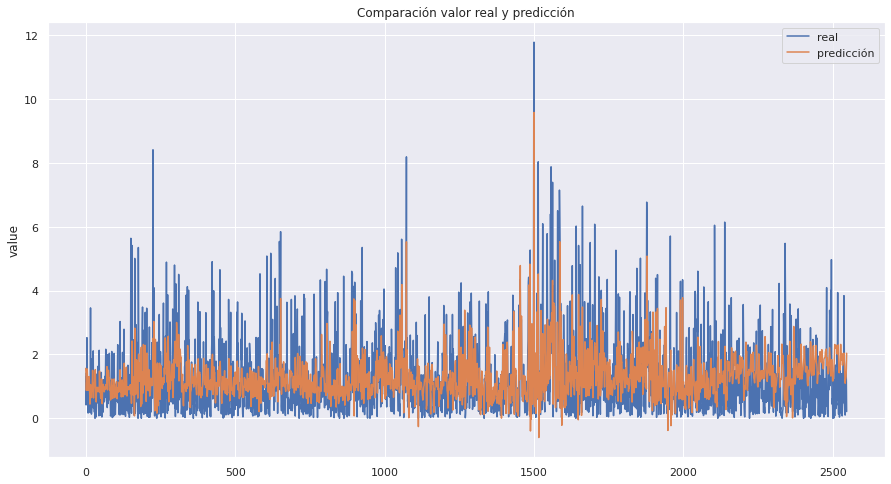

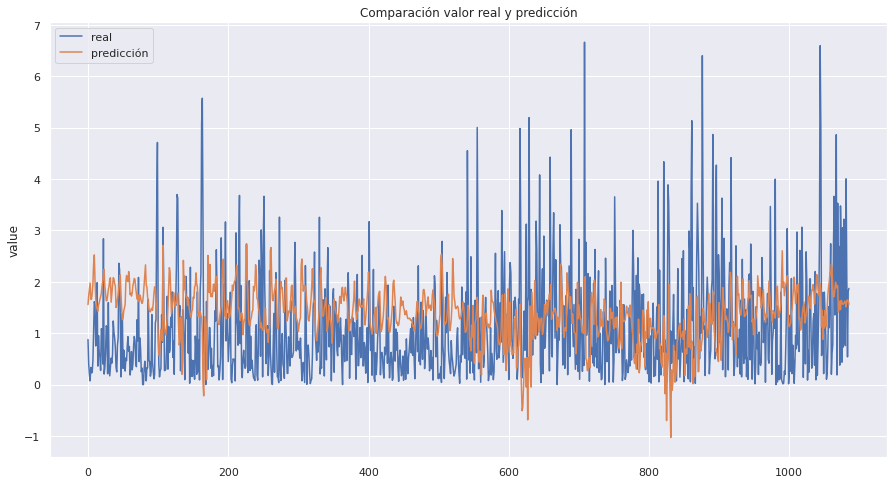

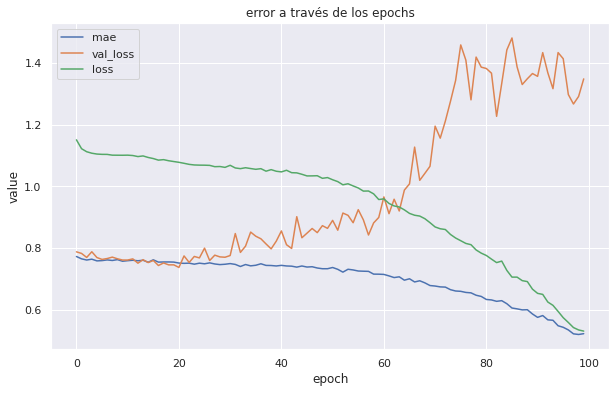

34/34 [==============================] - 0s 14ms/step
Evaluation metric results:
MSE is : 0.8822695578109593
MAE is : 0.66469040293542
RMSE is : 0.9392920513934733
MAPE is : 33.64378907590083
Evaluation metric results:
MSE is : 1.6055534235525943
MAE is : 1.003274278815754
RMSE is : 1.2671043459607398
MAPE is : 57.162708217874744
(2542, 15, 3) (2542, 1)
(1081, 15, 3) (1081, 1)
Epoch 1/100
128/128 [==============================] - 4s 12ms/step - loss: 1.1677 - mae: 0.7899 - val_loss: 0.8005 - val_mae: 0.6682
Epoch 2/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1314 - mae: 0.7715 - val_loss: 0.7972 - val_mae: 0.6717
Epoch 3/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1240 - mae: 0.7628 - val_loss: 0.7952 - val_mae: 0.6746
Epoch 4/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1179 - mae: 0.7678 - val_loss: 0.7944 - val_mae: 0.6785
Epoch 5/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1156 - mae

Epoch 59/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0754 - mae: 0.7539 - val_loss: 0.7979 - val_mae: 0.7020
Epoch 60/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0752 - mae: 0.7518 - val_loss: 0.7983 - val_mae: 0.7024
Epoch 61/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0742 - mae: 0.7534 - val_loss: 0.7971 - val_mae: 0.7014
Epoch 62/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0741 - mae: 0.7505 - val_loss: 0.7972 - val_mae: 0.7015
Epoch 63/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0747 - mae: 0.7530 - val_loss: 0.7970 - val_mae: 0.7017
Epoch 64/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0737 - mae: 0.7518 - val_loss: 0.7973 - val_mae: 0.7021
Epoch 65/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0736 - mae: 0.7526 - val_loss: 0.7973 - val_mae: 0.7021
Epoch 66/100
128/128 [==============================] - 1s 8ms

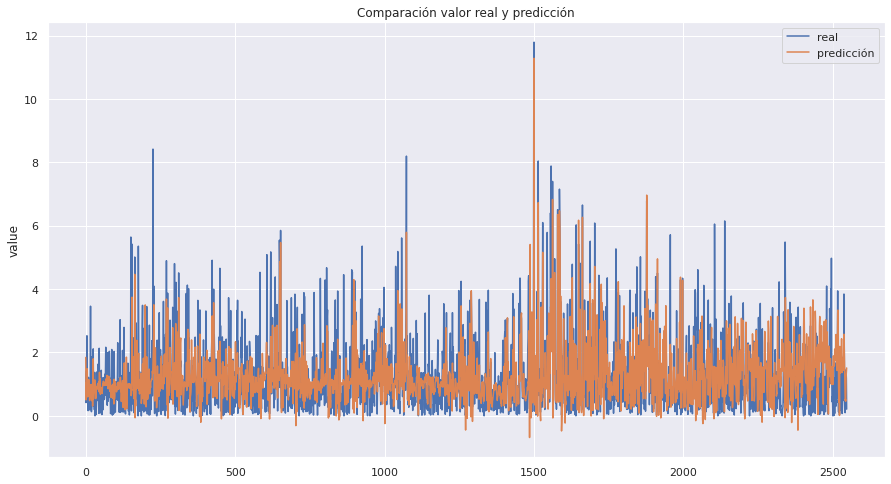

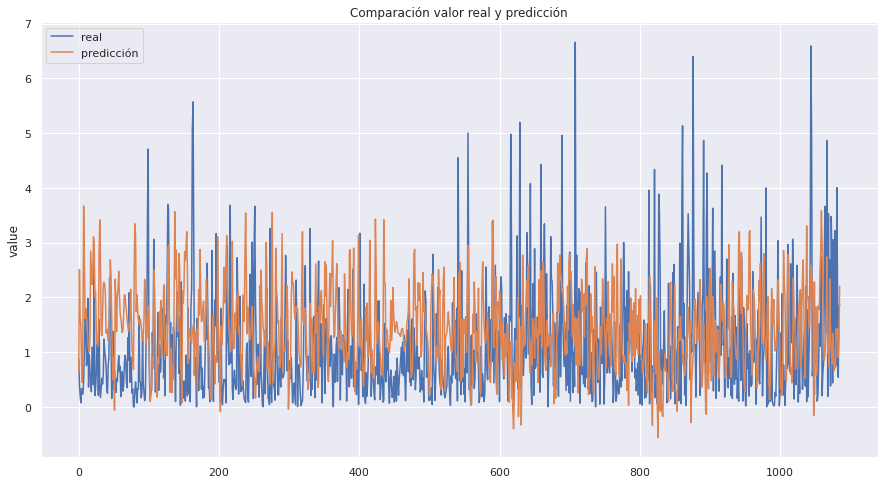

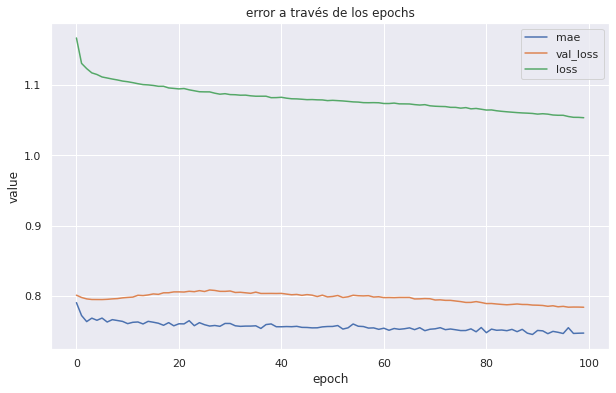

34/34 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.293538434955448
MAE is : 0.8347876411597231
RMSE is : 1.1373383115658453
MAPE is : 41.329329484185905
Evaluation metric results:
MSE is : 0.9892833249957909
MAE is : 0.7559230297890889
RMSE is : 0.994627229164671
MAPE is : 40.59832835598689
(2542, 15, 3) (2542, 1)
(1081, 15, 3) (1081, 1)
Epoch 1/100
128/128 [==============================] - 5s 14ms/step - loss: 1.1571 - mae: 0.7713 - val_loss: 0.8110 - val_mae: 0.6746
Epoch 2/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1321 - mae: 0.7721 - val_loss: 0.8082 - val_mae: 0.6790
Epoch 3/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1223 - mae: 0.7583 - val_loss: 0.8078 - val_mae: 0.6788
Epoch 4/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1190 - mae: 0.7670 - val_loss: 0.8072 - val_mae: 0.6847
Epoch 5/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1175 - mae

Epoch 59/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0753 - mae: 0.7539 - val_loss: 0.8128 - val_mae: 0.6994
Epoch 60/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0750 - mae: 0.7525 - val_loss: 0.8150 - val_mae: 0.7006
Epoch 61/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0729 - mae: 0.7535 - val_loss: 0.8122 - val_mae: 0.6989
Epoch 62/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0738 - mae: 0.7504 - val_loss: 0.8137 - val_mae: 0.6990
Epoch 63/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0752 - mae: 0.7532 - val_loss: 0.8157 - val_mae: 0.7023
Epoch 64/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0735 - mae: 0.7516 - val_loss: 0.8159 - val_mae: 0.7022
Epoch 65/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0732 - mae: 0.7536 - val_loss: 0.8147 - val_mae: 0.7004
Epoch 66/100
128/128 [==============================] - 1s 9ms

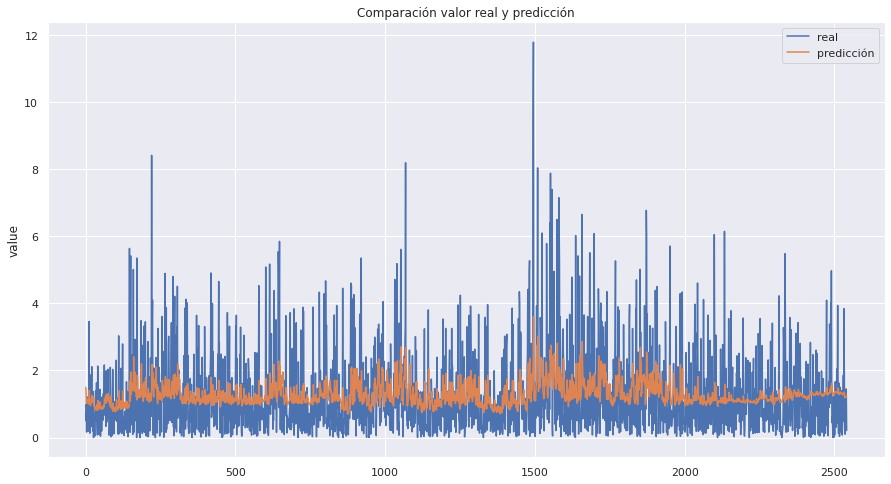

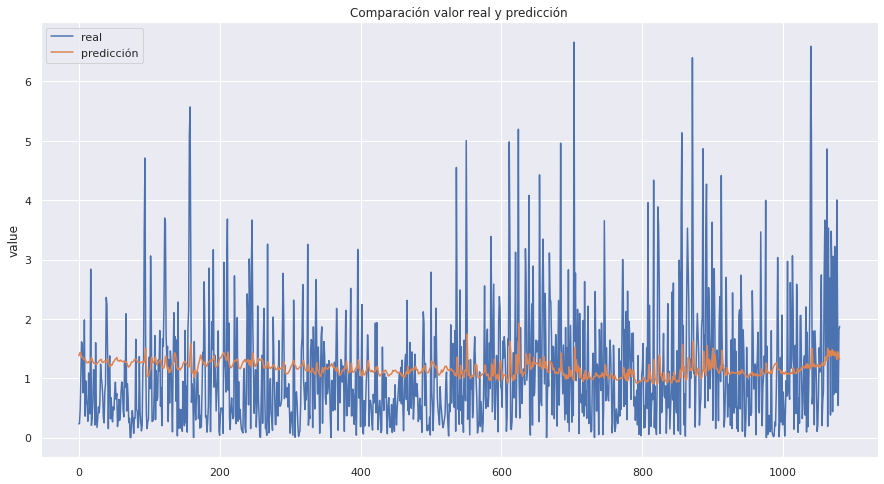

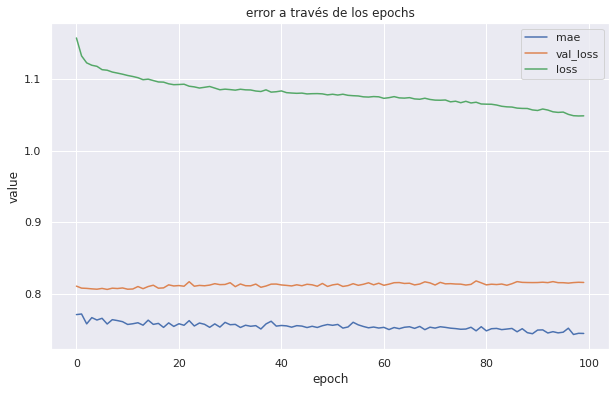

34/34 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.293344986029121
MAE is : 0.8335204281101197
RMSE is : 1.1372532638023605
MAPE is : 41.1003931038996
Evaluation metric results:
MSE is : 1.0148671245103476
MAE is : 0.758337148070588
RMSE is : 1.007406136823847
MAPE is : 40.114143475369445
(2542, 15, 3) (2542, 1)
(1081, 15, 3) (1081, 1)
Epoch 1/100
128/128 [==============================] - 4s 13ms/step - loss: 1.1435 - mae: 0.7682 - val_loss: 0.7919 - val_mae: 0.6787
Epoch 2/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1245 - mae: 0.7738 - val_loss: 0.7926 - val_mae: 0.6870
Epoch 3/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1126 - mae: 0.7575 - val_loss: 0.7903 - val_mae: 0.6779
Epoch 4/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1128 - mae: 0.7659 - val_loss: 0.7930 - val_mae: 0.6893
Epoch 5/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1107 - mae

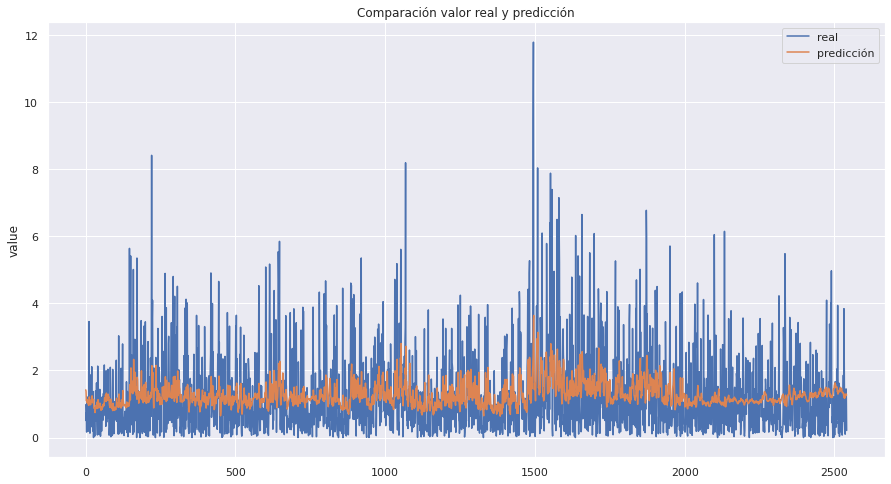

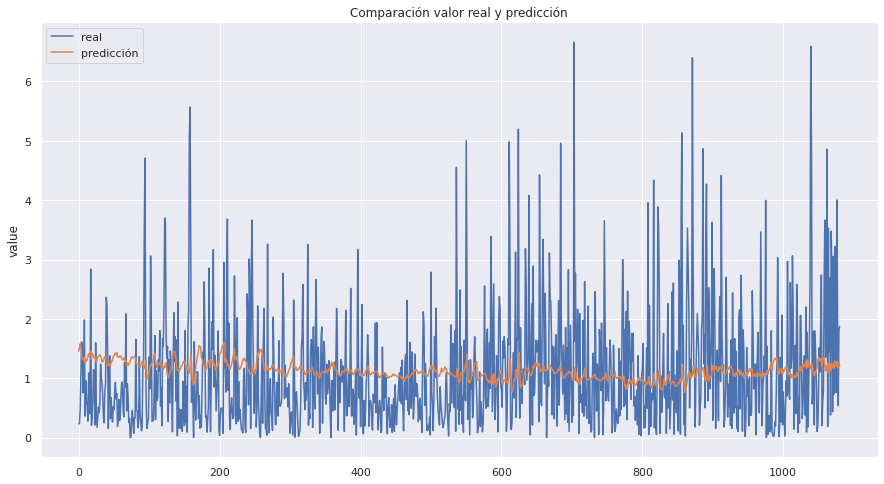

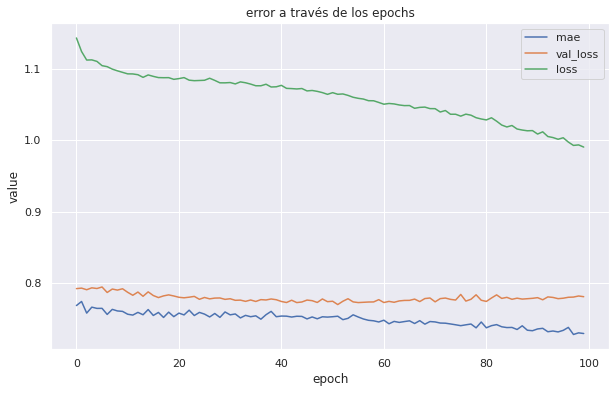

34/34 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.220141353430372
MAE is : 0.8089061266047756
RMSE is : 1.1046000875567465
MAPE is : 39.64575703079735
Evaluation metric results:
MSE is : 1.044302353210582
MAE is : 0.7516609892875975
RMSE is : 1.0219111278436017
MAPE is : 37.98072617080219
(2542, 15, 3) (2542, 1)
(1081, 15, 3) (1081, 1)
Epoch 1/100
128/128 [==============================] - 6s 18ms/step - loss: 1.1447 - mae: 0.7699 - val_loss: 0.8027 - val_mae: 0.6753
Epoch 2/100
128/128 [==============================] - 2s 13ms/step - loss: 1.1249 - mae: 0.7736 - val_loss: 0.7908 - val_mae: 0.6823
Epoch 3/100
128/128 [==============================] - 2s 13ms/step - loss: 1.1070 - mae: 0.7567 - val_loss: 0.7964 - val_mae: 0.6731
Epoch 4/100
128/128 [==============================] - 2s 13ms/step - loss: 1.1093 - mae: 0.7636 - val_loss: 0.7925 - val_mae: 0.6863
Epoch 5/100
128/128 [==============================] - 2s 13ms/step - loss: 1.1076 - 

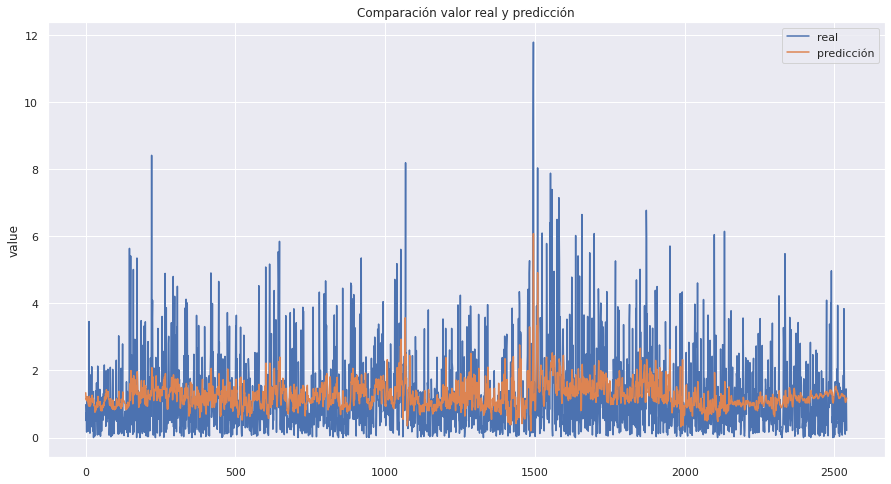

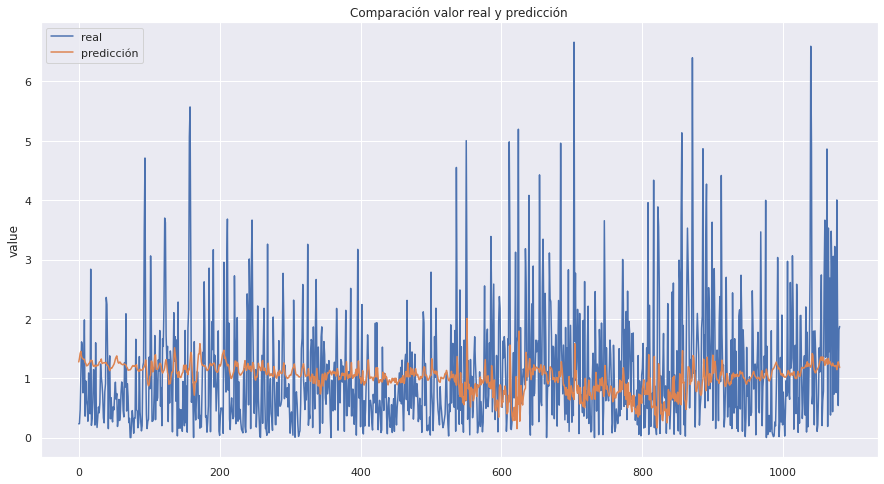

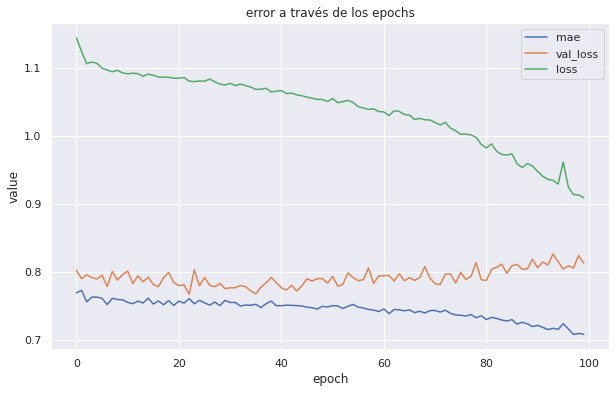

34/34 [==============================] - 0s 6ms/step
Evaluation metric results:
MSE is : 1.142620388389135
MAE is : 0.7910767914042963
RMSE is : 1.0689342301512919
MAPE is : 38.76489935557797
Evaluation metric results:
MSE is : 1.0547256080565066
MAE is : 0.7362744346606609
RMSE is : 1.0269983486143035
MAPE is : 36.06618479292028
(2542, 15, 3) (2542, 1)
(1081, 15, 3) (1081, 1)
Epoch 1/100
128/128 [==============================] - 6s 27ms/step - loss: 1.1427 - mae: 0.7696 - val_loss: 0.7967 - val_mae: 0.6777
Epoch 2/100
128/128 [==============================] - 3s 22ms/step - loss: 1.1214 - mae: 0.7729 - val_loss: 0.7831 - val_mae: 0.6862
Epoch 3/100
128/128 [==============================] - 3s 23ms/step - loss: 1.0978 - mae: 0.7558 - val_loss: 0.7992 - val_mae: 0.6854
Epoch 4/100
128/128 [==============================] - 3s 23ms/step - loss: 1.1046 - mae: 0.7608 - val_loss: 0.7922 - val_mae: 0.6960
Epoch 5/100
128/128 [==============================] - 3s 23ms/step - loss: 1.1075 -

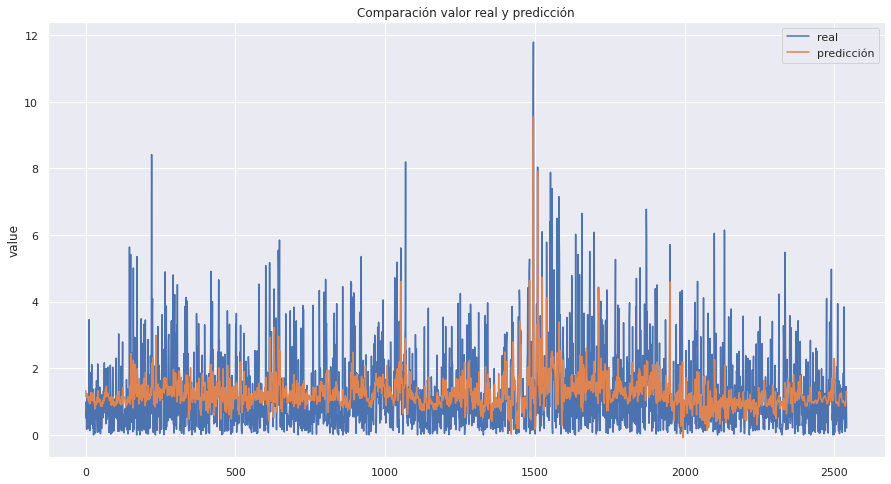

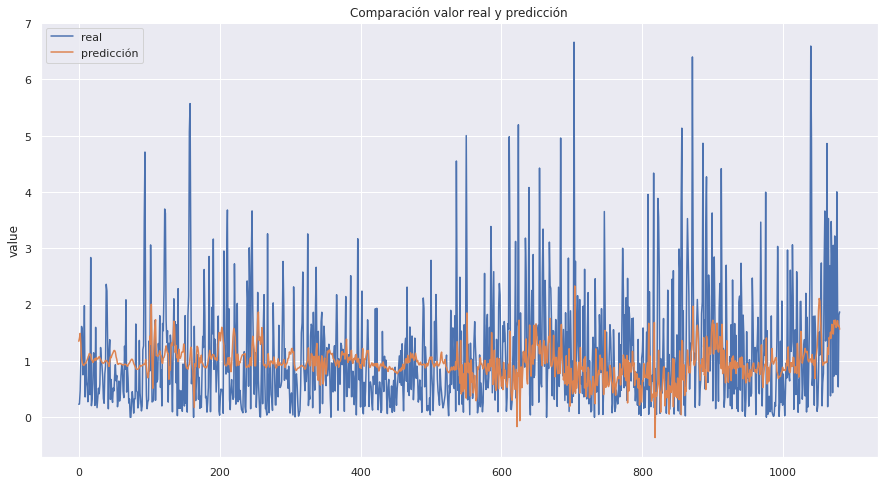

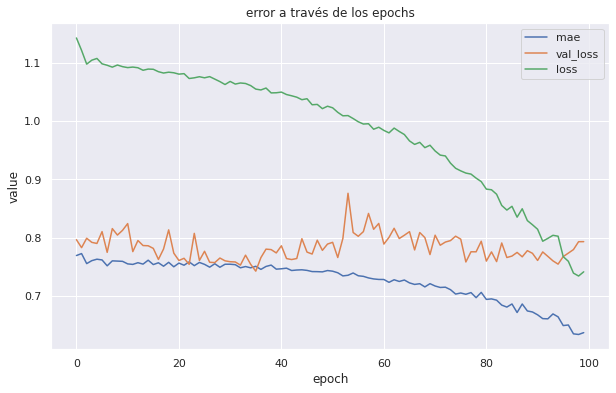

34/34 [==============================] - 0s 12ms/step
Evaluation metric results:
MSE is : 0.9735276431171591
MAE is : 0.7397131482510187
RMSE is : 0.9866750443368674
MAPE is : 37.405692328000185
Evaluation metric results:
MSE is : 1.1141359539702866
MAE is : 0.8326200021437535
RMSE is : 1.055526387150168
MAPE is : 47.35688542447622
(2542, 15, 3) (2542, 1)
(1081, 15, 3) (1081, 1)
Epoch 1/100
128/128 [==============================] - 9s 54ms/step - loss: 1.1394 - mae: 0.7680 - val_loss: 0.7872 - val_mae: 0.6715
Epoch 2/100
128/128 [==============================] - 6s 44ms/step - loss: 1.1203 - mae: 0.7725 - val_loss: 0.7728 - val_mae: 0.6823
Epoch 3/100
128/128 [==============================] - 6s 44ms/step - loss: 1.0954 - mae: 0.7560 - val_loss: 0.7899 - val_mae: 0.6838
Epoch 4/100
128/128 [==============================] - 6s 44ms/step - loss: 1.1039 - mae: 0.7593 - val_loss: 0.7836 - val_mae: 0.6936
Epoch 5/100
128/128 [==============================] - 6s 44ms/step - loss: 1.1077

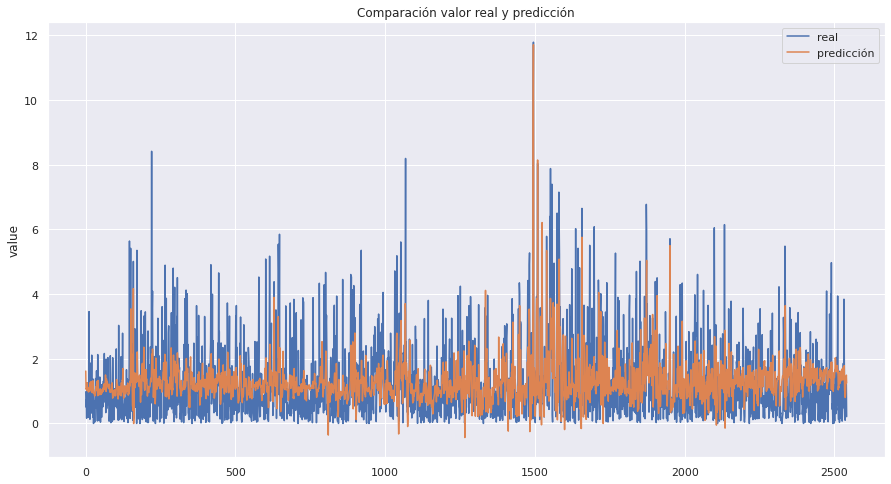

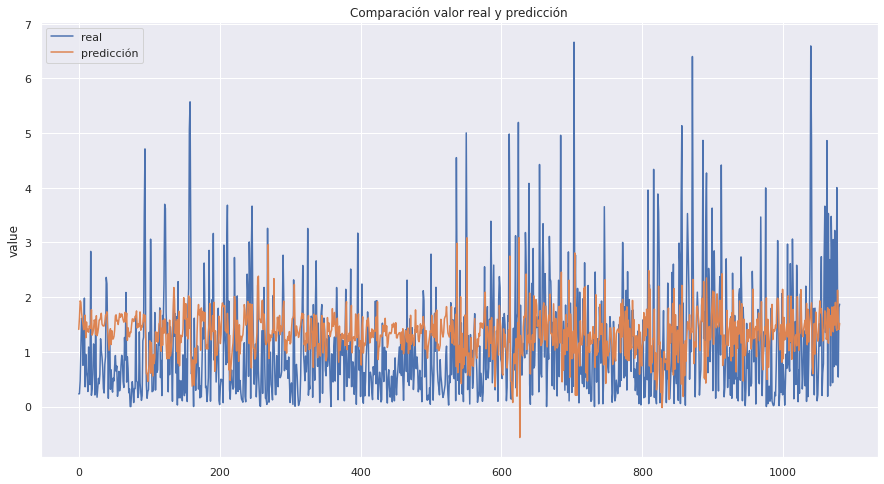

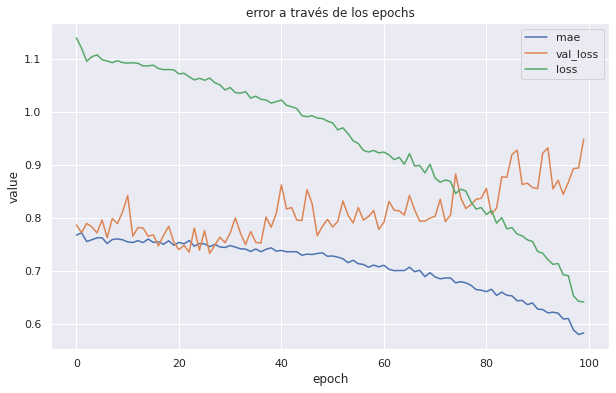

34/34 [==============================] - 1s 19ms/step
Evaluation metric results:
MSE is : 0.9274459671375495
MAE is : 0.7144679905990113
RMSE is : 0.9630399613398966
MAPE is : 37.37434349539075
Evaluation metric results:
MSE is : 1.4205915410422174
MAE is : 0.9500261007236551
RMSE is : 1.1918857080451202
MAPE is : 54.36154818207425


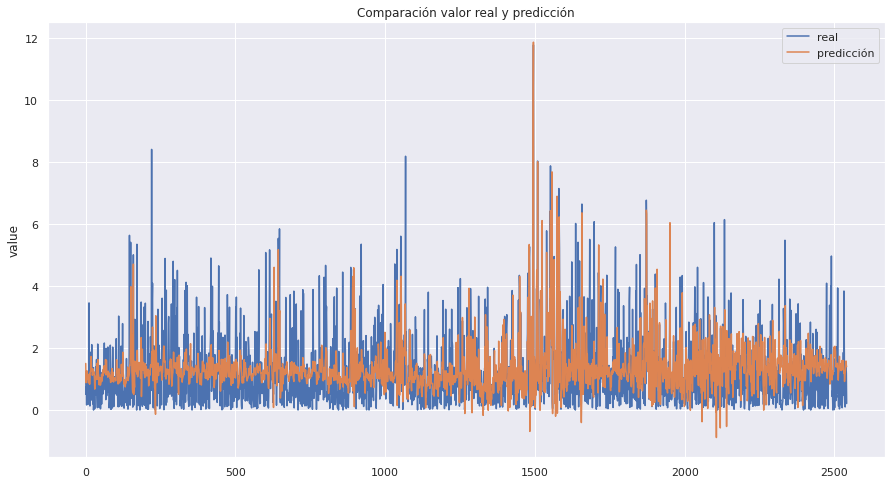

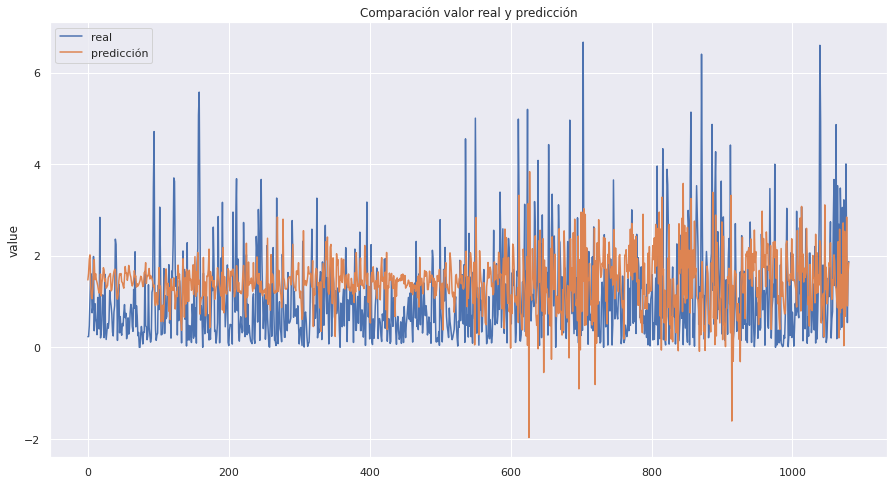

In [12]:
lags=[5,8,10,15]
neuronss=[16,32,64,128,256,512]
results_models={i:{} for i in lags}
for lg in lags:
    for neuron in neuronss:
        results_models[lg][neuron]=Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons=neuron,attributes=3,epochss=100,batch_sizze=16,lag=lg)